In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.spatial.distance import cdist
from scipy.linalg import expm
from scipy.linalg import logm
from scipy.linalg import eigh
from scipy.linalg import null_space
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import expm_multiply
from scipy.optimize import curve_fit
from scipy.integrate import simps 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.widgets import Slider

In [2]:
def small_FCC_lattice(a):
    
    x = np.array([1, 0, 0])
    y = np.array([0, 1, 0])
    z = np.array([0, 0, 1])

    offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

    # List of positions in a single unit cell for FCC structure
    fcc_positions = a*np.array([
        [0, 0, 0],  # Corner atom
        [1/2, 1/2, 0],  # Face center (x-y plane)
        [1/2, 0, 1/2],  # Face center (x-z plane)
        [0, 1/2, 1/2],  # Face center (y-z plane)
        [1, 1/2, 1/2],
        [1/2, 1, 1/2],
        [1/2, 1/2, 1],
        x, y, z, x+y, x+z, y+z,
        [1, 1, 1],  
        ])
    
    # List positions for second FCC points which lie inside first FCC unit cell
    fcc2_positions = offset + a*np.array([
        [0, 0, 0],  # Corner atom
        [1/2, 1/2, 0],  # Face center (x-y plane)
        [1/2, 0, 1/2],  # Face center (x-z plane)
        [0, 1/2, 1/2],  # Face center (y-z plane)
    ])

    R = []
    S = []
    for pos in fcc_positions:
        R.append(pos)
    for pos in fcc2_positions:
        S.append(pos)

    return np.array(R), np.array(S)

In [3]:
def FCC_lattice(a,size):

    x = a*np.array([1, 0, 0])
    y = a*np.array([0, 1, 0])
    z = a*np.array([0, 0, 1])

    offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

    # List of positions in a single unit cell for FCC structure
    fcc_positions = (a/2)*np.array([
        [0, 0, 0],  # Corner atom
        [1, 1, 0],  # Face center (x-y plane)
        [1, 0, 1],  # Face center (x-z plane)
        [0, 1, 1],  # Face center (y-z plane)
        ])

    R = []
    for l in range(-size, size+1):
        for m in range(-size, size+1):
            for n in range(-size, size+1):
                for pos in fcc_positions:
                    R.append(l*x + m*y + n*z + pos)
                    R.append(l*x + m*y + n*z + pos + offset)

    return np.array(R)

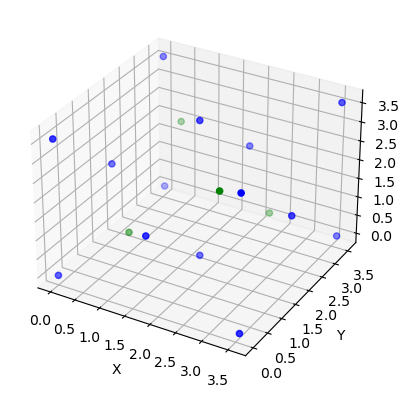

In [4]:
R, S = small_FCC_lattice(3.57)
# R = FCC_lattice(3.57,2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(R[:,0], R[:,1], R[:,2], color='b', marker='o')
ax.scatter(S[:,0], S[:,1], S[:,2], color='g', marker='o')
# ax.grid(False)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [5]:
#Check for duplicates (true means no duplicates)
unique_elements = set(tuple(arr) for arr in R)
print(len(unique_elements) == len(R))

True


In [6]:
#Randomly place 13C and electrons in lattice
R = FCC_lattice(3.57,12)

prob_C = 1.1*1e-2
prob_e = 30*1e-6
specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
carbons = random.sample(specials, int(len(R)*prob_C))
electrons = [pt for pt in specials if pt not in carbons]

S = np.zeros(R.shape)
T = np.zeros(R.shape)
for pos in carbons:
    S[pos,:] = R[pos,:]
for pos in electrons:
    T[pos,:] = R[pos,:]
    
carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
carbon_pts = np.array(carbon_pts)

e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
e_pts = np.array(e_pts)

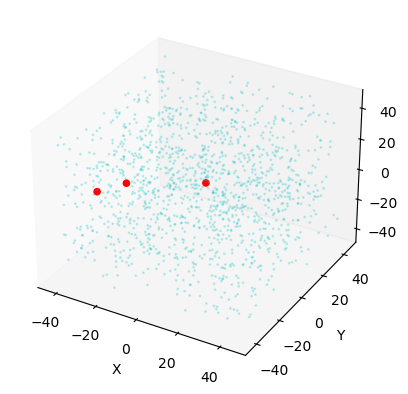

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(carbon_pts[:,0], carbon_pts[:,1], carbon_pts[:,2], color='c', marker='o', alpha = 0.2, s=1)
ax.scatter(e_pts[:,0], e_pts[:,1], e_pts[:,2], color='r', marker='o', alpha = 1, s=20)
ax.grid(False)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

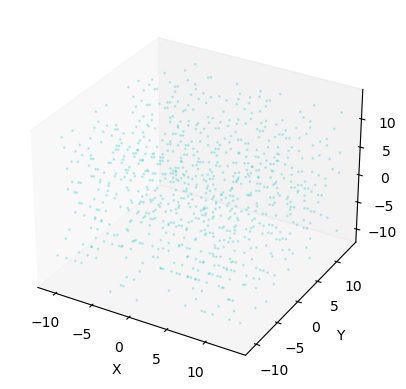

(823, 3)


In [3]:
a = 3.57
size = 3
prob_C=30e-2
prob_e=200e-6
    
# Total number of unit cells
grid_range = np.arange(-size, size + 1)
Ncells = len(grid_range) ** 3
Natoms = Ncells * 8  # 8 atoms per FCC diamond unit cell

# How many atoms to sample
num_C = int(Natoms * prob_C)
num_e = int(Natoms * prob_e)
total_specials = num_C + num_e

# Sample linear indices (0 to Natoms-1)
indices = np.random.choice(Natoms, total_specials, replace=False)
carbon_indices = np.random.choice(indices, num_C, replace=False)
electron_indices = np.setdiff1d(indices, carbon_indices, assume_unique=True)

# Convert linear index to (unit cell index, basis atom index)
unit_index = indices // 8
basis_index = indices % 8

# Map unit index back to (l, m, n) grid coordinates
n_grid = len(grid_range)
L = unit_index // (n_grid ** 2)
M = (unit_index // n_grid) % n_grid
N = unit_index % n_grid
L = L + grid_range[0]
M = M + grid_range[0]
N = N + grid_range[0]

# FCC + offset basis
basis = (a/2)*np.array([
    [0, 0, 0],
    [1, 1, 0],
    [1, 0, 1],
    [0, 1, 1],
    [0.5, 0.5, 0.5],
    [1.5, 1.5, 0.5],
    [1.5, 0.5, 1.5],
    [0.5, 1.5, 1.5],
])

# Construct positions
unit_coords = np.stack([L, M, N], axis=1) * a
special_positions = unit_coords + basis[basis_index]

# Split into carbon and electron positions
carbon_pts = special_positions[np.isin(indices, carbon_indices)]
e_pts = special_positions[np.isin(indices, electron_indices)]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(carbon_pts[:,0], carbon_pts[:,1], carbon_pts[:,2], color='c', marker='o', alpha = 0.2, s=1)
ax.scatter(e_pts[:,0], e_pts[:,1], e_pts[:,2], color='r', marker='o', alpha = 1, s=20)
ax.grid(False)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

print(carbon_pts.shape)

In [60]:
#mean nearest neighbor carbon distance
all_carbon_distances = cdist(carbon_pts,carbon_pts)
np.fill_diagonal(all_carbon_distances, np.inf)
nn_carbon_distance = np.min(all_carbon_distances, axis=1)
average_nn_carbon = np.mean(nn_carbon_distance)
print(average_nn_carbon, 'angstroms')

4.5263991675906565 angstroms


In [48]:
#mean nearest neighbor electron distance
all_electron_distances = cdist(e_pts,e_pts)
np.fill_diagonal(all_electron_distances, np.inf)
nn_electron_distance = np.min(all_electron_distances, axis=1)
average_nn_electron = np.mean(nn_electron_distance)
print(average_nn_electron, 'angstroms')

40.50627835711635 angstroms


In [49]:
#CC dipolar coupling with average nearest neighbor distance
mu_0 = 1.256e-6 #NA^-2
hbar = 1.055e-34 #Js
gamma_C = 10.7084e6 #Hz/T
gamma_e = 28024.951e6 #Hz/T
r1 = average_nn_carbon*1e-10
D_CC = 2*np.pi*(mu_0*gamma_C*gamma_C*hbar)/(4*np.pi*(r1**3))
print(D_CC, 'Hz')

78.11987111000447 Hz


In [15]:
#ee dipolar coupling with average nearest neighbor distance
mu_0 = 1.256e-6 #NA^-2
hbar = 1.055e-34 #Js
gamma_C = 10.7084e6 #Hz/T
gamma_e = 28.024951e9 #Hz/T
r2 = average_nn_electron*1e-10
D_ee = 2*np.pi*(mu_0*gamma_e*gamma_e*hbar)/(4*np.pi*(r2**3))
print(D_ee*1e-6, 'MHz')

0.4441621312905941 MHz


In [16]:
#Calculate spin diffusion barrier radius based on Khutsishvili equation
k_B = 1.38e-23
S = np.tanh((2*np.pi*gamma_e*hbar*9.4)/(2*k_B*100))
r3 = (average_nn_carbon*1e-10)*(S*(gamma_e/gamma_C))**(1/4)
print(r3*1e10, 'angstroms')

16.50913019787546 angstroms


In [17]:
# excitation BW = 25kHz
# Readout BW = 250kHz

# D_ij = 125e3
# r4 = ((mu_0*gamma_e*gamma_C*hbar)/(2*D_ij))**(1/3)
# print(r4*1e10, 'angstroms')

r4 = 7*1e-10
D_ij = (mu_0*gamma_e*gamma_C*hbar)/(2*(r4**3))
print(D_ij*1e-3, 'kHz')

57.96788173439546 kHz


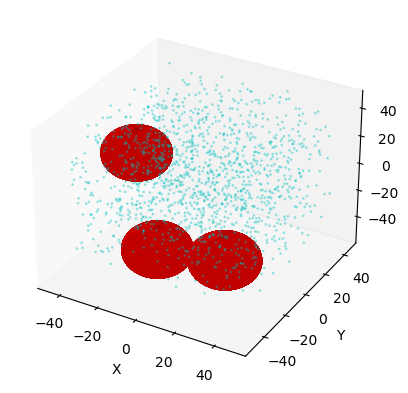

In [18]:
# Define the radius of the spheres
radius = r3*1e10

# Create a meshgrid for the sphere
resolution = 30
u = np.linspace(0, 2 * np.pi, resolution)
v = np.linspace(0, np.pi, resolution)
u, v = np.meshgrid(u, v)

# Parametric equations for the sphere
x_sphere = radius * np.outer(np.cos(u), np.sin(v))
y_sphere = radius * np.outer(np.sin(u), np.sin(v))
z_sphere = radius * np.outer(np.ones(np.size(u)), np.cos(v))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(carbon_pts[:,0], carbon_pts[:,1], carbon_pts[:,2], color='c', marker='o', alpha = 0.3, s=1)
# Plot spheres around each point
for pos in range(e_pts.shape[0]):
    ax.plot_surface(e_pts[pos][0] + x_sphere, e_pts[pos][1] + y_sphere, e_pts[pos][2] + z_sphere, color='red', alpha=1)
ax.grid(False)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [19]:
#Calculate the distance between each carbon and the nearest electron and then see if that distance is less than r3
r3 = 16*1e-10

if e_pts.shape[0] == 0:
    # No electron points; all carbon atoms are considered "outside"
    outside_pts = carbon_pts
    inside_pts = np.empty((0, 3))
else:
    diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
    distances = np.linalg.norm(diff, axis=2)
    min_distances = np.min(distances, axis=1)

    inside_pts = carbon_pts[min_distances < r3*1e10]
    outside_pts = carbon_pts[min_distances >= r3*1e10]

In [20]:
N_carbon = carbon_pts.shape[0]
N_e = e_pts.shape[0]
N_bulk = outside_pts.shape[0]
N_core = inside_pts.shape[0]

In [21]:
print(N_bulk)

1287


In [22]:
print((N_core/N_carbon)*100, '% of carbon inside barrier')

6.4 % of carbon inside barrier


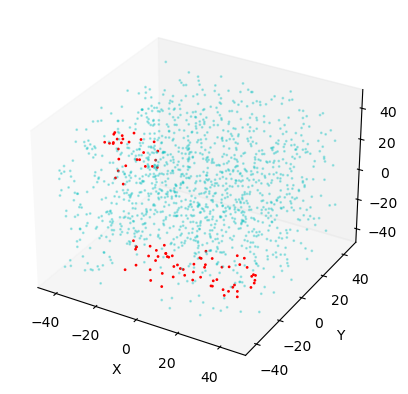

In [23]:
#carbons inside the barrier are plotted in red
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(inside_pts[:,0], inside_pts[:,1], inside_pts[:,2], color='r', marker='o', alpha = 1, s=1)
ax.scatter(outside_pts[:,0], outside_pts[:,1], outside_pts[:,2], color='c', marker='o', alpha = 0.3, s=1)
ax.grid(False)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [24]:
#Find the carbon closest to the origin
distances = np.sum(outside_pts**2, axis=1)
min_index = np.argmin(distances)
closest_pt = outside_pts[min_index]

print(closest_pt)

[4.4625 0.8925 0.8925]


In [25]:
shifted_pts = outside_pts - np.array(closest_pt)
print(shifted_pts[min_index])

[0. 0. 0.]


In [26]:
def azimuthal_angle(p1, p2):
    diff = p1 - p2
    norm_diff = diff/np.linalg.norm(diff)
    return np.arccos(norm_diff[2])

In [27]:
# import time
# start_time = time.time()

# #Calculate R matrix

# #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
# #(already similarly done 3 cells above)
# diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
# distances2 = np.linalg.norm(diff2, axis=2)

# R = np.zeros((N_bulk))
# rates = np.zeros((N_e))
# for carbon in range(N_bulk):
#     for e in range(N_e):
#         r = distances2[carbon,e]
#         angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
#         D = 1 - 3*(np.cos(angle))**2 
#         C = ((1/2)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
#         rates[e] = (1/2)*(C**2)*10e-3
#     R[carbon] = np.sum(rates)
#     rates = np.zeros((N_e))

# R = np.diag(R)

# end_time = time.time()
# print(end_time-start_time)

In [28]:
import time
start_time = time.time()

#Calculate W matrix
from scipy.spatial import cKDTree

threshold = 20
tree = cKDTree(shifted_pts)
pairs = tree.query_pairs(r=threshold, output_type='ndarray')  # shape: (num_pairs, 2)

W = np.zeros((N_bulk, N_bulk))
for i, j in pairs:
    diff = shifted_pts[i] - shifted_pts[j]
    dist = np.linalg.norm(diff)
    unit_vec = diff / dist
    angle = np.arccos(unit_vec[2])

    A = 1 - 3 * (np.cos(angle))**2
    B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
    W[i, j] = 0.5 * B**2
    W[j, i] = 0.5 * B**2  # symmetry

W = W - np.diag(np.sum(W, axis=0))

end_time = time.time()
print(end_time-start_time)

0.22798776626586914


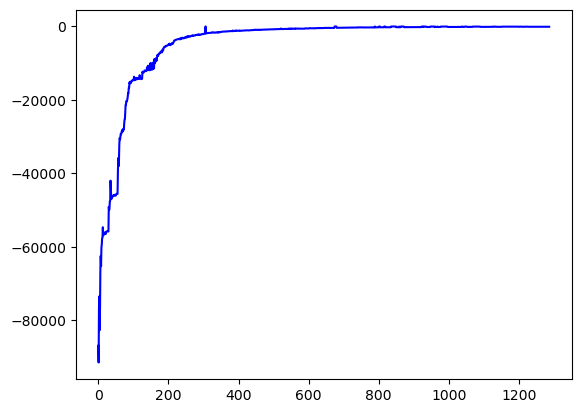

-91530.60336025931


In [66]:
eigenvalues = np.linalg.eigvals(W)

fig = plt.figure()
plt.plot(range(len(eigenvalues)), eigenvalues, color='b')  
plt.show()

print(np.min(eigenvalues))

In [22]:
import time
start_time = time.time()
M = W
# M = -R
# M = W-R
t_pts = 100
T = np.linspace(0, 0.1, t_pts)
alpha_0 = np.zeros(N_bulk)
alpha_0[min_index] = N_bulk
alpha = np.zeros((N_bulk, t_pts))

evals, evecs = eigh(M)
V_inv = np.linalg.inv(evecs)

# max_exp = 1000
# evals_clipped = np.clip(evals, -max_exp, max_exp)

V_alpha = V_inv @ alpha_0
for t in range(t_pts):
    alpha[:, t] = evecs @ (np.exp(evals * T[t]) * V_alpha)
    
end_time = time.time()
print(end_time-start_time)

1.0704913139343262


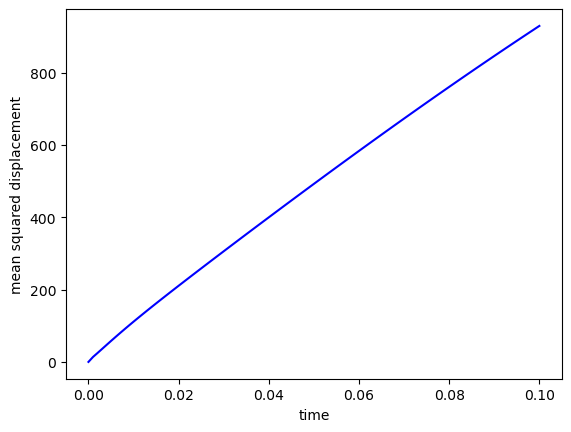

In [23]:
def calculate_mean_squared_distance(alpha, points, time):
    squared_distances = np.sum(points**2, axis=1)
    weighted_squares = alpha[:,time] * squared_distances
    mean_squared_distance = np.mean(weighted_squares)
    return mean_squared_distance
    
D = np.zeros(t_pts)
for t in range(t_pts):
    D[t] = calculate_mean_squared_distance(alpha, shifted_pts, t)
    

fig = plt.figure()
plt.plot(T, D, color='b')  
plt.xlabel('time')
plt.ylabel('mean squared displacement')
plt.show()

<IPython.core.display.Javascript object>


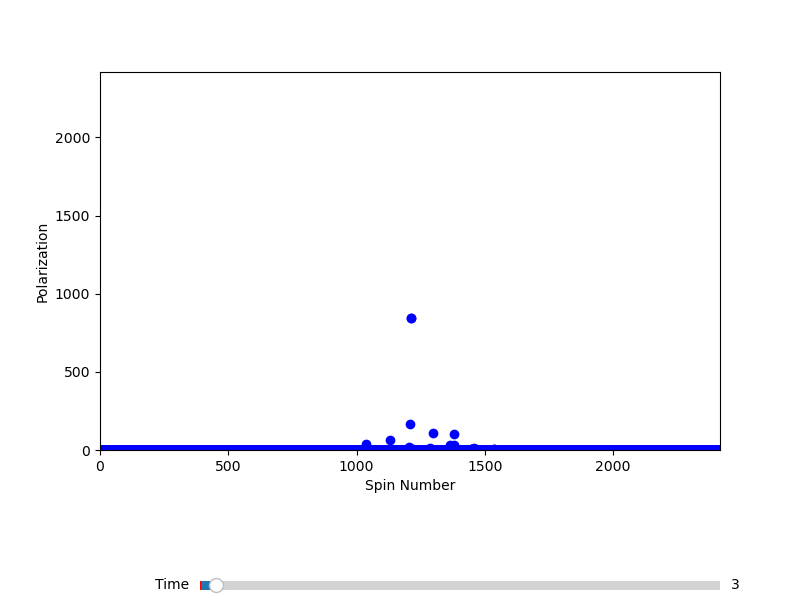

In [24]:
#Plot movie of polarization of each spin as a function of time

%matplotlib notebook

num_spins = N_bulk  # Number of spins
num_times = t_pts  # Number of time points


# Set up the figure and axis with more space for the slider
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the figure size if needed
plt.subplots_adjust(bottom=0.25)  # Adjust bottom to provide space for the slider

# Initial plot (time index = 0)
time_index = 0
sc = ax.scatter(range(num_spins), alpha[:, time_index], c='blue')

ax.set_xlabel("Spin Number")
ax.set_ylabel("Polarization")
ax.set_xlim(0, num_spins - 1)
ax.set_ylim(0, np.max(alpha))

# Create slider for time control
ax_slider = plt.axes([0.25, 0.01, 0.65, 0.03], facecolor='lightgoldenrodyellow')
slider = Slider(ax_slider, 'Time', 0, num_times - 1, valinit=0, valstep=1)

# Update function to update the plot based on the slider value
def update(val):
    time_index = int(slider.val)
    sc.set_offsets(np.column_stack((range(num_spins), alpha[:, time_index])))
    fig.canvas.draw_idle()

slider.on_changed(update)

plt.show()

(32, 100)
18.48072576522827


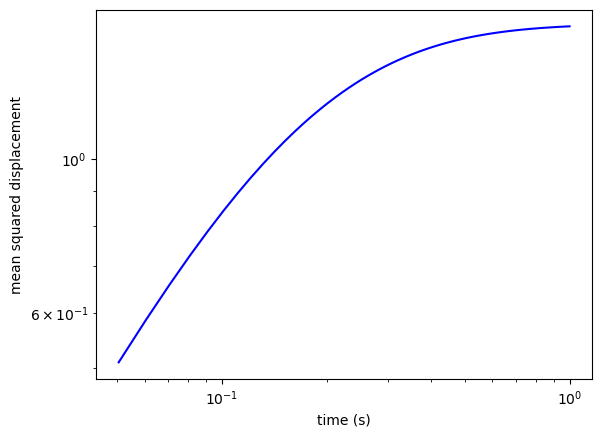

In [14]:
#Run different lattice configurations simultaneously using different CPU cores

from pathos.multiprocessing import ProcessingPool as Pool

import time
start_time = time.time()

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def FCC_lattice(a,size):

        x = a*np.array([1, 0, 0])
        y = a*np.array([0, 1, 0])
        z = a*np.array([0, 0, 1])

        offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

        # List of positions in a single unit cell for FCC structure
        fcc_positions = (a/2)*np.array([
            [0, 0, 0],  # Corner atom
            [1, 1, 0],  # Face center (x-y plane)
            [1, 0, 1],  # Face center (x-z plane)
            [0, 1, 1],  # Face center (y-z plane)
            ])

        R = []
        for l in range(-size, size+1):
            for m in range(-size, size+1):
                for n in range(-size, size+1):
                    for pos in fcc_positions:
                        R.append(l*x + m*y + n*z + pos)
                        R.append(l*x + m*y + n*z + pos + offset)

        return np.array(R)


    def place_specials(size):
        R = FCC_lattice(3.57,size)

        prob_C = 1.1*1e-2
        prob_e = 30*1e-6
        specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
        carbons = random.sample(specials, int(len(R)*prob_C))
        electrons = [pt for pt in specials if pt not in carbons]

        S = np.zeros(R.shape)
        T = np.zeros(R.shape)
        for pos in carbons:
            S[pos,:] = R[pos,:]
        for pos in electrons:
            T[pos,:] = R[pos,:]

        carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
        carbon_pts = np.array(carbon_pts)

        e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
        e_pts = np.array(e_pts)

        return carbon_pts, e_pts



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])



    def calculate_M(carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        distances = np.sum(outside_pts**2, axis=1)
        min_index = np.argmin(distances)
        closest_pt = outside_pts[min_index]
        shifted_pts = outside_pts - np.array(closest_pt)
        
        #Calculate W matrix
        from scipy.spatial import cKDTree

        threshold = 20
        tree = cKDTree(shifted_pts)
        pairs = tree.query_pairs(r=threshold, output_type='ndarray')  # shape: (num_pairs, 2)

        W = np.zeros((N_bulk, N_bulk))
        for i, j in pairs:
            diff = shifted_pts[i] - shifted_pts[j]
            dist = np.linalg.norm(diff)
            unit_vec = diff / dist
            angle = np.arccos(unit_vec[2])

            A = 1 - 3 * (np.cos(angle))**2
            B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
            W[i, j] = 0.5 * B**2 * tau_d
            W[j, i] = 0.5 * B**2 * tau_d# symmetry

        W = W - np.diag(np.sum(W, axis=0))

        M = W
        return N_bulk, M, shifted_pts, min_index

    
    
    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha



    def calculate_mean_squared_distance(alpha, points, time):
        squared_distances = np.sum(points**2, axis=1)
        weighted_squares = alpha[:,time] * squared_distances
        mean_squared_distance = np.mean(weighted_squares)
        return mean_squared_distance
    
#     tau_p, tau_d = params
    
    size = 12
    t_pts = 100
    T = np.linspace(0,1,t_pts)
    P = np.zeros(len(T))
    carbon_pts, e_pts = place_specials(size)
    N_bulk, M, shifted_pts, min_index = calculate_M(carbon_pts, e_pts, 1, 1)
#     alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha_0 = np.zeros(N_bulk)
    alpha_0[min_index] = 1
    alpha = solve_ode(N_bulk, T, alpha_0, M)
#     P = np.sum(alpha, axis=0)

    D = np.zeros(t_pts)
    for t in range(t_pts):
        D[t] = calculate_mean_squared_distance(alpha, shifted_pts, t)
        
    return D


iterations = 32
inputs = [(1)] * iterations

pool = Pool()
results = pool.map(run_simulation, inputs)

print(np.array(results).shape)
end_time = time.time()
print(end_time-start_time)

T = np.linspace(0,1,100)
D_avg = (np.sum(np.array(results), axis=0))/iterations
fig = plt.figure()
plt.loglog(T[5:], D_avg[5:], color='b')
plt.xlabel('time (s)')
plt.ylabel('mean squared displacement')
plt.show()

(100, 100)
43.77259707450867


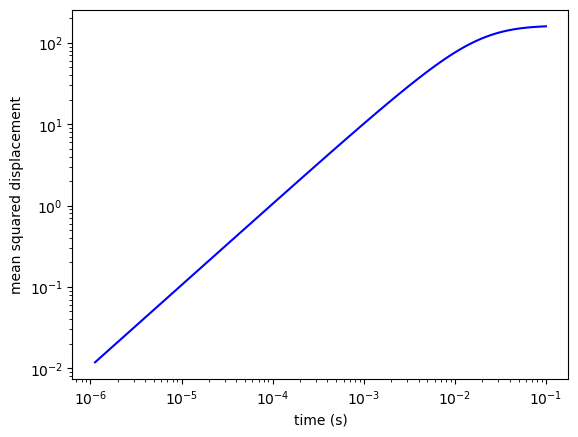

In [277]:
from pathos.multiprocessing import ProcessingPool as Pool

import time
start_time = time.time()

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    import numpy as np

    def sample_special_positions(a, size, prob_C, prob_e):
        # Total number of unit cells
        grid_range = np.arange(-size, size + 1)
        Ncells = len(grid_range) ** 3
        Natoms = Ncells * 8  # 8 atoms per FCC diamond unit cell

        # How many atoms to sample
        num_C = int(Natoms * prob_C)
        num_e = int(Natoms * prob_e)
        total_specials = num_C + num_e

        # Sample linear indices (0 to Natoms-1)
        indices = np.random.choice(Natoms, total_specials, replace=False)
        carbon_indices = np.random.choice(indices, num_C, replace=False)
        electron_indices = np.setdiff1d(indices, carbon_indices, assume_unique=True)

        # Convert linear index to (unit cell index, basis atom index)
        unit_index = indices // 8
        basis_index = indices % 8

        # Map unit index back to (l, m, n) grid coordinates
        n_grid = len(grid_range)
        L = unit_index // (n_grid ** 2)
        M = (unit_index // n_grid) % n_grid
        N = unit_index % n_grid
        L = L + grid_range[0]
        M = M + grid_range[0]
        N = N + grid_range[0]

        # FCC + offset basis
        basis = (a/2)*np.array([
            [0, 0, 0],
            [1, 1, 0],
            [1, 0, 1],
            [0, 1, 1],
            [0.5, 0.5, 0.5],
            [1.5, 1.5, 0.5],
            [1.5, 0.5, 1.5],
            [0.5, 1.5, 1.5],
        ])

        # Construct positions
        unit_coords = np.stack([L, M, N], axis=1) * a
        special_positions = unit_coords + basis[basis_index]

        # Split into carbon and electron positions
        carbon_pts = special_positions[np.isin(indices, carbon_indices)]
        e_pts = special_positions[np.isin(indices, electron_indices)]

        return carbon_pts, e_pts

    

    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])



    def calculate_M(carbon_pts, e_pts, tau_p, tau_d):
        if e_pts.shape[0] == 0:
            outside_pts = carbon_pts
            inside_pts = np.empty((0, 3))
        else:
            diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
            distances = np.linalg.norm(diff, axis=2)
            min_distances = np.min(distances, axis=1)

            inside_pts = carbon_pts[min_distances < r3*1e10]
            outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        distances = np.sum(outside_pts**2, axis=1)
        min_index = np.argmin(distances)
        closest_pt = outside_pts[min_index]
        shifted_pts = outside_pts - np.array(closest_pt)
        
        #Calculate W matrix
        from scipy.spatial import cKDTree

        threshold = 20
        tree = cKDTree(shifted_pts)
        pairs = tree.query_pairs(r=threshold, output_type='ndarray')  # shape: (num_pairs, 2)

        W = np.zeros((N_bulk, N_bulk))
        for i, j in pairs:
            diff = shifted_pts[i] - shifted_pts[j]
            dist = np.linalg.norm(diff)
            unit_vec = diff / dist
            angle = np.arccos(unit_vec[2])

            A = 1 - 3 * (np.cos(angle))**2
            B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
            W[i, j] = 0.5 * B**2 * tau_d
            W[j, i] = 0.5 * B**2 * tau_d # symmetry

        W = W - np.diag(np.sum(W, axis=0))

        M = W
        return N_bulk, M, shifted_pts, min_index

    
    
    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha



    def calculate_mean_squared_distance(alpha, points, time):
        squared_distances = np.sum(points**2, axis=1)
        weighted_squares = alpha[:,time] * squared_distances
        mean_squared_distance = np.sum(weighted_squares)
        return mean_squared_distance
    
#     tau_p, tau_d = params
    
    size = 3
    t_pts = 100
    T = np.logspace(-6,-1,t_pts)
    P = np.zeros(len(T))
    carbon_pts, e_pts = sample_special_positions(3.57, size, 30e-2, 30e-6)
    N_bulk, M, shifted_pts, min_index = calculate_M(carbon_pts, e_pts, 1, 0.007)
#     alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha_0 = np.zeros(N_bulk)
    alpha_0[min_index] = 1
    alpha = solve_ode(N_bulk, T, alpha_0, M)
#     P = np.sum(alpha, axis=0)

    D = np.zeros(t_pts)
    for t in range(t_pts):
        D[t] = calculate_mean_squared_distance(alpha, shifted_pts, t)
        
    return D


iterations = 100
inputs = [(1)] * iterations

pool = Pool()
# pool.restart()
results = pool.map(run_simulation, inputs)

print(np.array(results).shape)
end_time = time.time()
print(end_time-start_time)

T = np.logspace(-6,-1,100)
D_avg = (np.sum(np.array(results), axis=0))/iterations
fig = plt.figure()
plt.loglog(T[1:], D_avg[1:], color='b')
plt.xlabel('time (s)')
plt.ylabel('mean squared displacement')
plt.show()

# np.savez("MSD_0.5_size18_100Itr_v2.npz", time=T, msd=np.array(results))

C:\Users\Suber\AppData\Local\Temp\ipykernel_37404\113841145.py:9: RuntimeWarning: overflow encountered in power
  return 6*D * t**alpha


D = 13881820528.491814 alpha = 0.9952529340450583


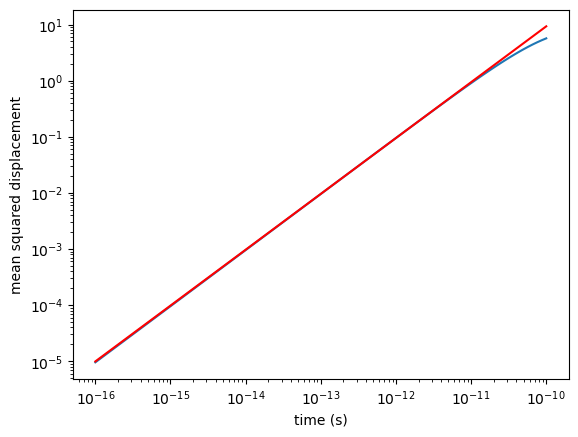

In [42]:
def find_cutoff_index(msd, threshold):
    max_msd = np.max(msd)
    for i in range(len(msd)):
        if msd[i] > threshold * max_msd:
            return i
    return len(msd)

def diffusion_fit(t, alpha, D):
    return 6*D * t**alpha

i_start = 1
i_end = find_cutoff_index(D_avg, 0.03)

time_fit = T[i_start:i_end]
msd_fit = D_avg[i_start:i_end]

popt, pcov = curve_fit(diffusion_fit, time_fit, msd_fit, p0=[1, 1e6])
alpha, D = popt
        
print("D =", D, "alpha =", alpha)
    
plt.figure()
plt.loglog(T, D_avg)
plt.loglog(T, 6*D * T**alpha, color='r')
plt.xlabel('time (s)')
plt.ylabel('mean squared displacement')
plt.show()

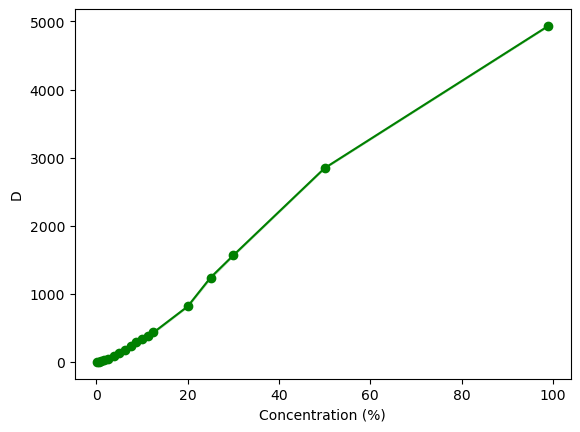

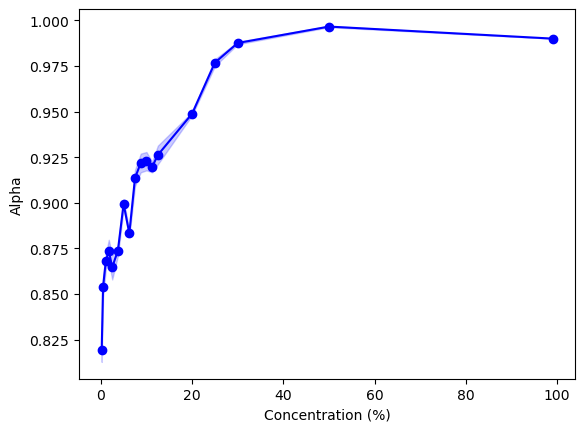

D = [2.534000e+00 7.320000e+00 2.010200e+01 3.448600e+01 5.233600e+01
 8.815000e+01 1.364740e+02 1.715860e+02 2.344620e+02 2.912100e+02
 3.321540e+02 3.771300e+02 4.344500e+02 8.173480e+02 1.240102e+03
 1.567226e+03 2.846852e+03 4.933558e+03]
alpha = [0.8192 0.854  0.8678 0.8738 0.8646 0.8738 0.8994 0.8832 0.9136 0.9218
 0.9228 0.9196 0.9262 0.9488 0.9768 0.9876 0.9966 0.99  ]
D_error =  [ 0.07340845  0.10178409  0.1787378   0.26000923  0.58553634  0.69857569
  0.53658625  0.93525868  2.0287955   4.68516211  7.7695882   4.13249852
  8.0393945   4.06964018 13.43060219  5.4664684   2.82585265  0.6576163 ]
alpha_error = [0.00646467 0.00557853 0.00420856 0.0059154  0.00666093 0.0029853
 0.00244295 0.00158493 0.0044596  0.00513342 0.00503905 0.00292027
 0.00511781 0.00086718 0.00186333 0.00066933 0.00035777 0.        ]


In [281]:
D_mat = np.array([
    [2.42, 2.66, 2.53, 2.76, 2.30], [7.31, 7.44, 7.67, 7.18, 7.00], [20.62, 19.74, 19.89, 20.55, 19.71],
    [34.96, 33.83, 34.35, 35.34, 33.95], [52.22, 52.72, 50.08, 52.51, 54.15], [88.39, 88.52, 90.23, 85.38, 88.23],
    [135.07,135.98,135.72,137.13,138.47], [173.51, 174.07, 171.01, 171.14, 168.20], [232.73,230.56,243.15,231.43,234.44],
    [295.13,280.83,281.05,309.12,289.92], [317.96, 355.87, 313.49, 350.05, 323.40], [385.17,378.47,367.78,365.43,388.80],
    [459.35,411.85,415.76,443.48,441.81], [808.88,809.52,823.00,812.86,832.48], [1293.72,1201.62,1237.64,1239.57,1227.96],
    [1575.91,1564.48,1563.77,1547.97,1584.00], [2842.94,2852.53,2855.95,2839.15,2843.69], 
    [4934.95,4930.92,4933.16,4934.83,4933.93]
])
alpha_mat = np.array([
    [0.830, 0.800, 0.818, 0.808, 0.840], [0.851, 0.838, 0.849, 0.856, 0.876], [0.871, 0.868, 0.851, 0.869, 0.880],
    [0.878, 0.871, 0.895, 0.871, 0.854], [0.865, 0.860, 0.841, 0.870, 0.887], [0.863, 0.875, 0.870, 0.881, 0.880],
    [0.895, 0.909, 0.895, 0.896, 0.902], [0.886, 0.887, 0.882, 0.877, 0.884], [0.910, 0.900, 0.927, 0.908, 0.923], 
    [0.923, 0.910, 0.914, 0.943, 0.919], [0.915, 0.935, 0.914, 0.938, 0.912], [0.919, 0.926, 0.913, 0.912, 0.928],
    [0.945, 0.916, 0.913, 0.931, 0.926], [0.947, 0.947, 0.952, 0.948, 0.950], [0.985, 0.974, 0.976, 0.975, 0.974],
    [0.987, 0.989, 0.985, 0.988, 0.989], [0.997, 0.996, 0.996, 0.996, 0.998], 
    [0.990, 0.990, 0.990, 0.990, 0.990]
])


x = np.array((0.2, 0.5, 1.1, 1.75, 2.5, 3.75, 5, 6.25, 7.5, 8.75, 10, 11.25, 12.5, 20, 25, 30, 50, 99))
alpha = np.mean(alpha_mat, axis=1)
D = np.mean(D_mat, axis=1)

alpha_error = np.sqrt(np.var(alpha_mat, axis=1)/5)
D_error = np.sqrt(np.var(D_mat, axis=1)/5)

plt.figure()
plt.plot(x, D, 'go-', label='D')
plt.fill_between(x, D - D_error, D + D_error,
                 color='green', alpha=0.2, label='Error band')
plt.xlabel("Concentration (%)")
plt.ylabel("D")
plt.show()

plt.figure()
plt.plot(x, alpha, 'bo-', label='alpha')
plt.fill_between(x, alpha - alpha_error, alpha + alpha_error,
                 color='blue', alpha=0.2, label='Error band')
plt.xlabel("Concentration (%)")
plt.ylabel("Alpha")
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\Diffusivity.eps", format='eps', dpi=300)
# for i in range(len(x)):
#     print(x[i], "% concentration: D =", D[i], ", alpha =", alpha[i])
print("D =", D)
print("alpha =", alpha)
print("D_error = ", D_error)
print("alpha_error =", alpha_error)

In [265]:
def get_labels(size, prob_C, prob_e):
    # Total number of unit cells
    grid_range = np.arange(-size, size + 1)
    Ncells = len(grid_range) ** 3
    Natoms = Ncells * 8  # 8 atoms per FCC diamond unit cell

    # How many atoms to sample
    num_C = int(Natoms * prob_C)
    num_e = int(Natoms * prob_e)

    return num_C


concentration = 30e-2
for size in range(1,10):
    num_C = get_labels(size, concentration, 30e-6)
    print(size, 'corresponds to', num_C, 'spins')

1 corresponds to 64 spins
2 corresponds to 300 spins
3 corresponds to 823 spins
4 corresponds to 1749 spins
5 corresponds to 3194 spins
6 corresponds to 5272 spins
7 corresponds to 8100 spins
8 corresponds to 11791 spins
9 corresponds to 16461 spins


In [204]:
from pathos.multiprocessing import ProcessingPool as Pool
import time

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    import numpy as np

    def sample_special_positions(a, size, prob_C, prob_e):
        # Total number of unit cells
        grid_range = np.arange(-size, size + 1)
        Ncells = len(grid_range) ** 3
        Natoms = Ncells * 8  # 8 atoms per FCC diamond unit cell

        # How many atoms to sample
        num_C = int(Natoms * prob_C)
        num_e = int(Natoms * prob_e)
        total_specials = num_C + num_e

        # Sample linear indices (0 to Natoms-1)
        indices = np.random.choice(Natoms, total_specials, replace=False)
        carbon_indices = np.random.choice(indices, num_C, replace=False)
        electron_indices = np.setdiff1d(indices, carbon_indices, assume_unique=True)

        # Convert linear index to (unit cell index, basis atom index)
        unit_index = indices // 8
        basis_index = indices % 8

        # Map unit index back to (l, m, n) grid coordinates
        n_grid = len(grid_range)
        L = unit_index // (n_grid ** 2)
        M = (unit_index // n_grid) % n_grid
        N = unit_index % n_grid
        L = L + grid_range[0]
        M = M + grid_range[0]
        N = N + grid_range[0]

        # FCC + offset basis
        basis = (a/2)*np.array([
            [0, 0, 0],
            [1, 1, 0],
            [1, 0, 1],
            [0, 1, 1],
            [0.5, 0.5, 0.5],
            [1.5, 1.5, 0.5],
            [1.5, 0.5, 1.5],
            [0.5, 1.5, 1.5],
        ])

        # Construct positions
        unit_coords = np.stack([L, M, N], axis=1) * a
        special_positions = unit_coords + basis[basis_index]

        # Split into carbon and electron positions
        carbon_pts = special_positions[np.isin(indices, carbon_indices)]
        e_pts = special_positions[np.isin(indices, electron_indices)]

        return carbon_pts, e_pts

    

    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])



    def calculate_M(carbon_pts, e_pts, tau_p, tau_d):
        if e_pts.shape[0] == 0:
            outside_pts = carbon_pts
            inside_pts = np.empty((0, 3))
        else:
            diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
            distances = np.linalg.norm(diff, axis=2)
            min_distances = np.min(distances, axis=1)

            inside_pts = carbon_pts[min_distances < r3*1e10]
            outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        distances = np.sum(outside_pts**2, axis=1)
        min_index = np.argmin(distances)
        closest_pt = outside_pts[min_index]
        shifted_pts = outside_pts - np.array(closest_pt)
        
        #Calculate W matrix
        from scipy.spatial import cKDTree

        threshold = 20
        tree = cKDTree(shifted_pts)
        pairs = tree.query_pairs(r=threshold, output_type='ndarray')  # shape: (num_pairs, 2)

        W = np.zeros((N_bulk, N_bulk))
        for i, j in pairs:
            diff = shifted_pts[i] - shifted_pts[j]
            dist = np.linalg.norm(diff)
            unit_vec = diff / dist
            angle = np.arccos(unit_vec[2])

            A = 1 - 3 * (np.cos(angle))**2
            B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
            W[i, j] = 0.5 * B**2 * tau_d
            W[j, i] = 0.5 * B**2 * tau_d# symmetry

        W = W - np.diag(np.sum(W, axis=0))

        M = W
        return N_bulk, M, shifted_pts, min_index

    
    
    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha



    def calculate_mean_squared_distance(alpha, points, time):
        squared_distances = np.sum(points**2, axis=1)
        weighted_squares = alpha[:,time] * squared_distances
        mean_squared_distance = np.sum(weighted_squares)
        return mean_squared_distance
    
#     tau_p, tau_d = params
    
    size = params["size"]    
    t_pts = 100
    T = np.logspace(-3,1,t_pts)
    P = np.zeros(len(T))
    carbon_pts, e_pts = sample_special_positions(3.57, size, 1.1e-2, 30e-6)
    N_bulk, M, shifted_pts, min_index = calculate_M(carbon_pts, e_pts, 1, 0.007)
#     alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha_0 = np.zeros(N_bulk)
    alpha_0[min_index] = 1
    alpha = solve_ode(N_bulk, T, alpha_0, M)
#     P = np.sum(alpha, axis=0)

    D = np.zeros(t_pts)
    for t in range(t_pts):
        D[t] = calculate_mean_squared_distance(alpha, shifted_pts, t)
        
    return D


iterations = 100
size_list = range(5,15+1)

for size in size_list:
    print(f"Running size = {size}")
    start_time = time.time()
    
    inputs = [{"size": size}] * iterations  # same size, multiple runs
    pool = Pool()
    pool.restart()
    results = pool.map(run_simulation, inputs)
    pool.close()
    pool.join()

    T = np.logspace(-3, 1, 100)
    D_avg = np.mean(results, axis=0)

    # Save results
    filename = f"MSD_1.1_size{size}_100Itr_v4.npz"
    np.savez(filename, time=T, msd=np.array(results))

    print(f"Size {size} completed in {time.time() - start_time:.2f} seconds")


Running size = 5
Size 5 completed in 1.66 seconds
Running size = 6
Size 6 completed in 3.47 seconds
Running size = 7
Size 7 completed in 7.62 seconds
Running size = 8
Size 8 completed in 4.94 seconds
Running size = 9
Size 9 completed in 7.33 seconds
Running size = 10
Size 10 completed in 12.63 seconds
Running size = 11
Size 11 completed in 18.02 seconds
Running size = 12
Size 12 completed in 30.00 seconds
Running size = 13
Size 13 completed in 51.43 seconds
Running size = 14
Size 14 completed in 83.67 seconds
Running size = 15
Size 15 completed in 342.58 seconds


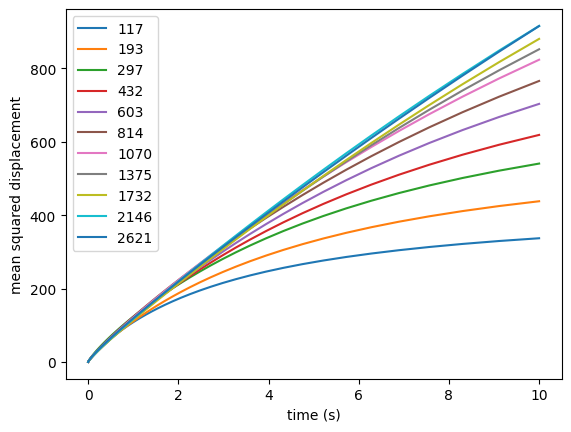

In [3]:
# Define sizes and corresponding labels
# sizes = [8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22, 24, 26] #1.1%

sizes = range(5,15+1)
concentration = 1.1e-2

#1.1%
# labels = {
#     8: "400", 9: "580", 10: "770", 11: "1020", 12: "1300", 
#     13: "1620", 14: "2000", 15: "2420", 16: "2950", 18: "4130", 
#     20: "5660", 22: "7450", 24: "9520", 26: "12100"
# }

def get_labels(size, prob_C, prob_e):
    # Total number of unit cells
    grid_range = np.arange(-size, size + 1)
    Ncells = len(grid_range) ** 3
    Natoms = Ncells * 8  # 8 atoms per FCC diamond unit cell

    # How many atoms to sample
    num_C = int(Natoms * prob_C)
    num_e = int(Natoms * prob_e)

    return num_C

labels = {}

for size in sizes:
    num_C = get_labels(size, concentration, 30e-6)
    labels[size] = str(num_C)
    
# Store time and MSD data
results = {}

for size in sizes:
    filename = f"MSD_{round(concentration*1e2,2)}_size{size}_100Itr_v4.npz"
    data = np.load(filename)
    
    time = data["time"]
    msd = data["msd"]
    msd_avg = np.mean(msd, axis=0)  
    
    results[size] = (time, msd_avg)

# Plotting
plt.figure()
for size in sizes:
    time, msd_avg = results[size]
    plt.plot(time, msd_avg, label=labels[size])

plt.xlabel('time (s)')
plt.ylabel('mean squared displacement')
plt.legend()
plt.show()

117 spins: alpha = 0.8276217869296818 D = 18.347843683575572
193 spins: alpha = 0.8382379285177977 D = 18.00743323615403
297 spins: alpha = 0.8474235188613657 D = 21.609339883543313
432 spins: alpha = 0.8325655639266949 D = 18.810473602248276
603 spins: alpha = 0.9018126526740213 D = 19.943127838338576
814 spins: alpha = 0.8323120335561078 D = 19.177292767225527
1070 spins: alpha = 0.865816349877453 D = 20.186578831668616
1375 spins: alpha = 0.8745924274790318 D = 19.032025472775718
1732 spins: alpha = 0.8650335156040528 D = 18.792402032194136
2146 spins: alpha = 0.842032200427939 D = 18.363762220399117
2621 spins: alpha = 0.838777528489041 D = 19.33004124137461


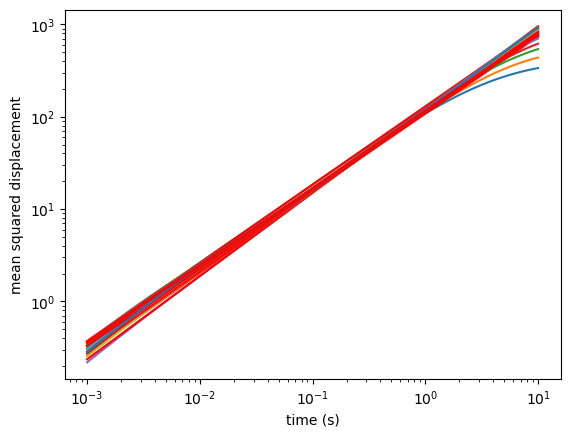

In [5]:
def find_cutoff_index(msd, threshold):
    max_msd = np.max(msd)
    for i in range(len(msd)):
        if msd[i] > threshold * max_msd:
            return i
    return len(msd)

def diffusion_fit(t, alpha, D):
    return 6*D * t**alpha


fit_results = {}

for size in sizes:
    time, msd_avg = results[size]
    
#     min_threshold = 0.001 * np.max(msd_avg)
#     i_start = np.argmax(msd_avg > min_threshold)
    i_start = 1
    i_end = find_cutoff_index(msd_avg, 0.03)
    
    time_fit = time[i_start:i_end]
    msd_fit = msd_avg[i_start:i_end]
    
    if len(time_fit) >= 3:  # minimum points for reliable fit
        popt, pcov = curve_fit(diffusion_fit, time_fit, msd_fit, p0=[1, 1])
        alpha, D = popt
        fit_results[size] = (alpha, D)
    else:
        fit_results[size] = (np.nan, np.nan)  # or skip
        
    
plt.figure()
for size in sizes:
    time, msd_avg = results[size]
    alpha, D = fit_results[size]
    print(labels[size], 'spins: alpha =', alpha, 'D =', D)
    plt.loglog(time, msd_avg, label=labels[size])
    plt.loglog(time, 6*D * time**alpha, color='r')
    
# plt.ylim([0.001, 10])
plt.xlabel('time (s)')
plt.ylabel('mean squared displacement')
# plt.legend()
plt.show()

In [6]:
n = len(sizes)
N = np.zeros(n)
D_values = np.zeros(n)      
alpha_values = np.zeros(n)  
counter = 0
for size in sizes:
    alpha, D = fit_results[size]
    alpha_values[counter] = alpha
    D_values[counter] = D
    counter = counter + 1

print("alpha =", np.mean(alpha_values), "\pm", np.sqrt(np.var(alpha_values)/n))
print("D =", np.mean(D_values), "\pm", np.sqrt(np.var(D_values)/n))

alpha = 0.851475046031199 \pm 0.0065515066895805
D = 19.23639280086341 \pm 0.29495923313504013


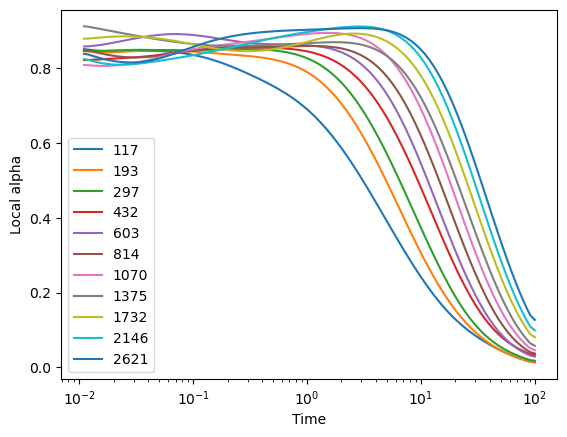

In [99]:
plt.figure()
for size in sizes:
    time, msd_avg = results[size]
    alpha, D = fit_results[size]
    log_t = np.log(time[1:])
    log_msd = np.log(msd_avg[1:])
    alpha_local = np.gradient(log_msd, log_t)
    plt.plot(time[1:], alpha_local, label=labels[size])
    
plt.xlabel("Time")
plt.ylabel("Local alpha")
plt.legend()
plt.xscale("log")

Text(0.5, 1.0, 'Scaling with 1/L^4')

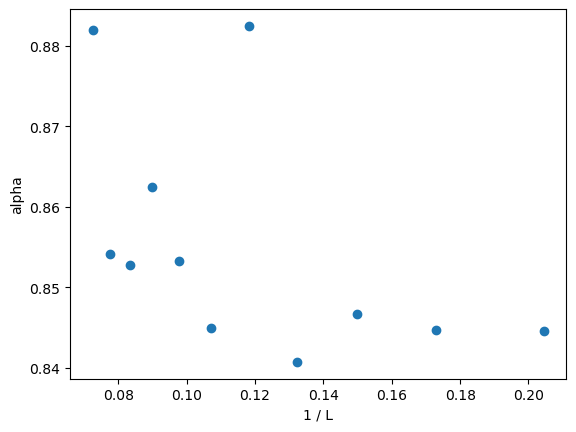

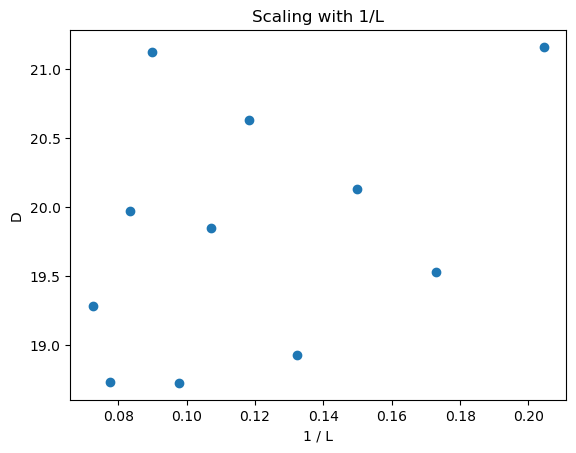

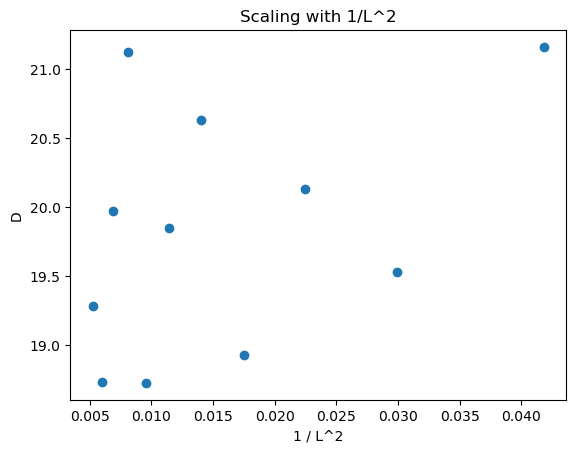

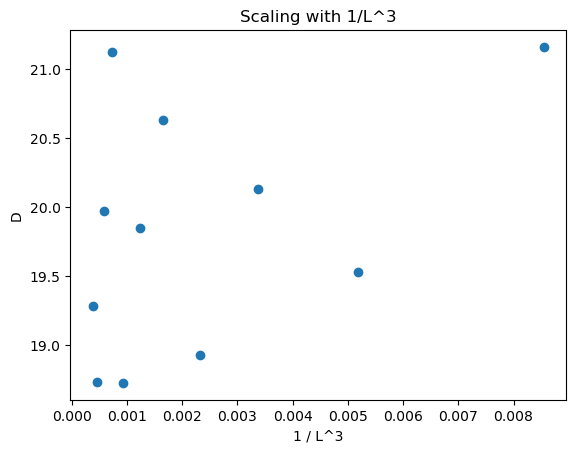

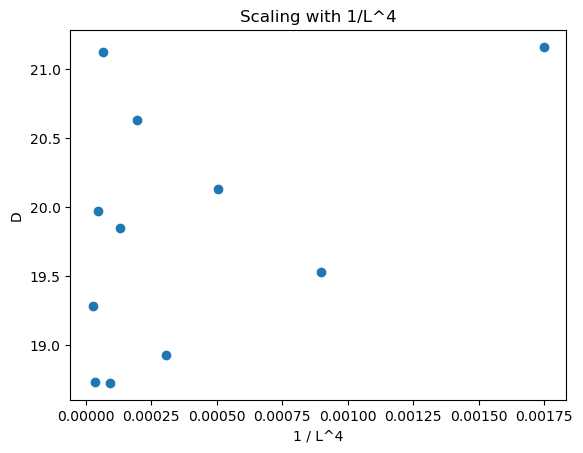

In [100]:
n = len(sizes)
N = np.zeros(n)
D_values = np.zeros(n)      
alpha_values = np.zeros(n)  
counter = 0
for size in sizes:
    alpha, D = fit_results[size]
    alpha_values[counter] = alpha
    D_values[counter] = D
    N[counter] = float(labels[size])
    counter = counter + 1

L = N**(1/3)
inv_L = 1/L
    
plt.figure()
plt.scatter(inv_L, alpha_values)
plt.xlabel('1 / L')
plt.ylabel('alpha')

plt.figure()
plt.scatter(inv_L, D_values)
plt.xlabel('1 / L')
plt.ylabel('D')
plt.title("Scaling with 1/L")

plt.figure()
plt.scatter(inv_L**2, D_values)
plt.xlabel('1 / L^2')
plt.ylabel('D')
plt.title("Scaling with 1/L^2")

plt.figure()
plt.scatter(inv_L**3, D_values)
plt.xlabel('1 / L^3')
plt.ylabel('D')
plt.title("Scaling with 1/L^3")

plt.figure()
plt.scatter(inv_L**4, D_values)
plt.xlabel('1 / L^4')
plt.ylabel('D')
plt.title("Scaling with 1/L^4")

D(infinite) = 19.481235471598943


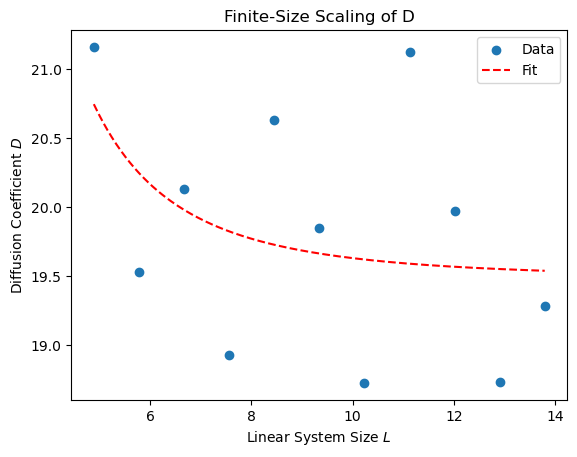

mean alpha = 0.8553334206847439 plus/minus 0.01391660547127787


In [101]:
def infinite_size_fit(L, D_inf, A):
    return D_inf + A/L**3

popt, pcov = curve_fit(infinite_size_fit, L, D_values)

D_inf, A = popt

print('D(infinite) =', D_inf)

plt.figure()
plt.scatter(L, D_values, label='Data')

L_smooth = np.linspace(min(L), max(L), 200)
plt.plot(L_smooth, D_inf + A/L_smooth**3, 'r--', label='Fit')

plt.xlabel("Linear System Size $L$")
plt.ylabel("Diffusion Coefficient $D$")
plt.title("Finite-Size Scaling of D")
plt.legend()
plt.show()

print('mean alpha =', np.mean(alpha_values), 'plus/minus', np.std(alpha_values))

# def infinite_size_fit(L, alpha_inf, A):
#     return alpha_inf + A/L**3

# popt, pcov = curve_fit(infinite_size_fit, L, alpha_values)

# alpha_inf, A = popt

# print('alpha(infinite) =', alpha_inf)

# plt.figure()
# plt.scatter(L, alpha_values, label='Data')

# L_smooth = np.linspace(min(L), max(L), 200)
# plt.plot(L_smooth, alpha_inf + A/L_smooth**3, 'r--', label='Fit')

# plt.xlabel("Linear System Size")
# plt.ylabel("Diffusion Exponent alpha")
# plt.title("Finite-Size Scaling of alpha")
# plt.legend()
# plt.show()

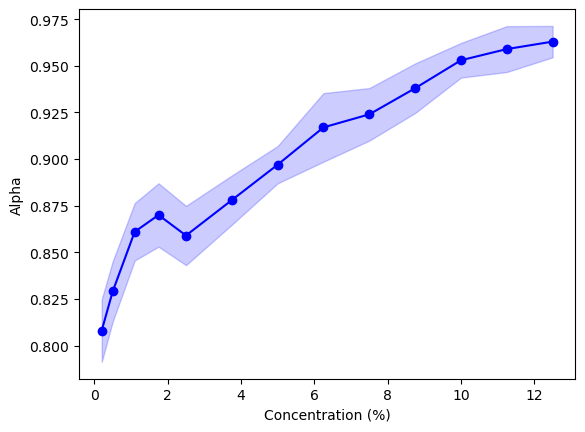

In [133]:
x = np.array((0.2, 0.5, 1.1, 1.75, 2.5, 3.75, 5, 6.25, 7.5, 8.75, 10, 11.25, 12.5))
alpha = np.array((0.808, 0.829, 0.861, 0.870, 0.859, 0.878, 0.897, 0.917, 0.924, 0.938, 0.953, 0.959, 0.963))
alpha_error = np.array((0.0168, 0.0162, 0.0154, 0.0170, 0.0159, 0.0132, 0.010, 0.0184, 0.0141, 0.0133,
                        0.00930, 0.0123, 0.00842))
D_constant = np.array((0.0381))

plt.figure()
plt.fill_between(x, alpha - alpha_error, alpha + alpha_error,
                 color='blue', alpha=0.2, label='Error band')
plt.plot(x, alpha, 'bo-', label='alpha')

plt.xlabel("Concentration (%)")
plt.ylabel("Alpha")
# plt.legend()
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\Diffusivity.eps", format='eps', dpi=300)

(1, 100)
148.03548955917358


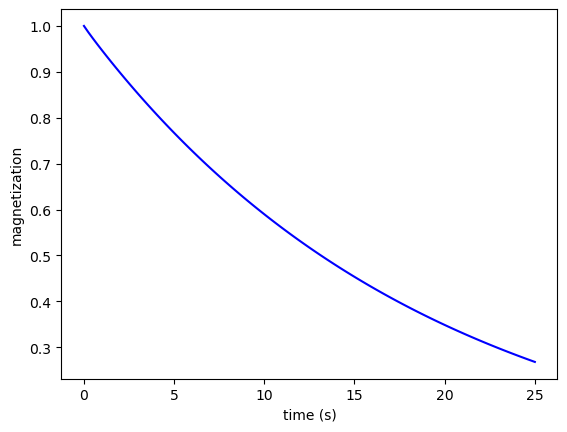

In [27]:
#Run different lattice configurations simultaneously using different CPU cores

from pathos.multiprocessing import ProcessingPool as Pool

import time
start_time = time.time()

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def FCC_lattice(a,size):

        x = a*np.array([1, 0, 0])
        y = a*np.array([0, 1, 0])
        z = a*np.array([0, 0, 1])

        offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

        # List of positions in a single unit cell for FCC structure
        fcc_positions = (a/2)*np.array([
            [0, 0, 0],  # Corner atom
            [1, 1, 0],  # Face center (x-y plane)
            [1, 0, 1],  # Face center (x-z plane)
            [0, 1, 1],  # Face center (y-z plane)
            ])

        R = []
        for l in range(-size, size+1):
            for m in range(-size, size+1):
                for n in range(-size, size+1):
                    for pos in fcc_positions:
                        R.append(l*x + m*y + n*z + pos)
                        R.append(l*x + m*y + n*z + pos + offset)

        return np.array(R)


    def place_specials(size):
        R = FCC_lattice(3.57,size)

        prob_C = 1.1*1e-2
        prob_e = 30*1e-6
        specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
        carbons = random.sample(specials, int(len(R)*prob_C))
        electrons = [pt for pt in specials if pt not in carbons]

        S = np.zeros(R.shape)
        T = np.zeros(R.shape)
        for pos in carbons:
            S[pos,:] = R[pos,:]
        for pos in electrons:
            T[pos,:] = R[pos,:]

        carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
        carbon_pts = np.array(carbon_pts)

        e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
        e_pts = np.array(e_pts)

        return carbon_pts, e_pts



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])



    def calculate_M(carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
        diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances2 = np.linalg.norm(diff2, axis=2)

        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
                r = distances2[carbon,e]
                angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((1/2)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        from scipy.spatial import cKDTree

        threshold = 20
        tree = cKDTree(outside_pts)
        pairs = tree.query_pairs(r=threshold, output_type='ndarray')  # shape: (num_pairs, 2)

        W = np.zeros((N_bulk, N_bulk))
        for i, j in pairs:
            diff = outside_pts[i] - outside_pts[j]
            dist = np.linalg.norm(diff)
            unit_vec = diff / dist
            angle = np.arccos(unit_vec[2])

            A = 1 - 3 * (np.cos(angle))**2
            B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
            W[i, j] = 0.5 * B**2 * tau_d
            W[j, i] = 0.5 * B**2 * tau_d# symmetry

        W = W - np.diag(np.sum(W, axis=0))

        M = W-R
        return N_bulk, M



    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha
    
    
    tau_p, tau_d = params
    
    size = 12
    T = np.linspace(0,25,100)
    P = np.zeros(len(T))
    carbon_pts, e_pts = place_specials(size)
    N_bulk, M = calculate_M(carbon_pts, e_pts, tau_p, tau_d)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    return P


iterations = 1
inputs = [(9.89e-7, 1.6e-2)] * iterations

pool = Pool()
results = pool.map(run_simulation, inputs)

print(np.array(results).shape)
end_time = time.time()
print(end_time-start_time)

T = np.linspace(0,25,100)
P_avg = (np.sum(np.array(results), axis=0))/iterations
fig = plt.figure()
plt.plot(T, P_avg, color='b')
plt.xlabel('time (s)')
plt.ylabel('magnetization')
plt.show()

RMSE product: 0.00017034898237148927


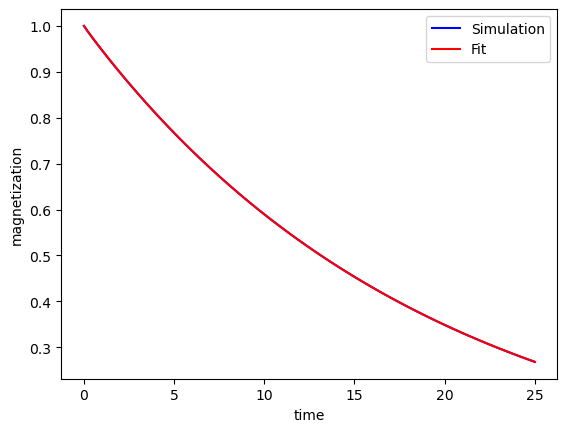

In [30]:
#Fit the data

def product_exp(x, a, b):
    return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

def purely_stretched(x, a):
    return np.exp(-np.sqrt(a*x)) 

def monoexp(x, a):
    return np.exp(-a*x)

# Fit the data
popt, pcov = curve_fit(product_exp, T, P_avg, bounds=([0, 0], [1, 1]))

# # popt = optimal values for a, b, c
# print("Fitted parameters:", popt)
# # Optional: Get standard deviation errors
# perr = np.sqrt(np.diag(pcov))
# print("Parameter errors:", perr)

y_fit = product_exp(T, *popt)
residuals = P_avg - y_fit
rmse_product = np.sqrt(np.mean(residuals**2))
print("RMSE product:", rmse_product)

# Plot the data and the fitted curve
fig = plt.figure()
plt.plot(T, P_avg, color='b', label="Simulation")
plt.plot(T, product_exp(T, *popt), color='red', label="Fit")
# plt.semilogy(np.sqrt(T), P_avg, color='b', label="Simulation")
# plt.semilogy(np.sqrt(T), product_exp(T, *popt), color='red', label="Fit")
plt.legend()
plt.xlabel("time")
plt.ylabel("magnetization")
plt.show()

# popt, pcov = curve_fit(purely_stretched, T, P_avg, bounds=([0], [1]))
# y_fit = purely_stretched(T, *popt)
# residuals = P_avg - y_fit
# rmse_purely_stretched = np.sqrt(np.mean(residuals**2))
# print("RMSE purely stretched:", rmse_purely_stretched)
# fig = plt.figure()
# plt.plot(T, P_avg, color='b', label="Simulation")
# plt.plot(T, purely_stretched(T, *popt), color='red', label="Fit")
# plt.legend()
# plt.xlabel("time")
# plt.ylabel("magnetization")
# plt.show()


# popt, pcov = curve_fit(monoexp, T, P_avg, bounds=([0], [1]))
# y_fit = monoexp(T, *popt)
# residuals = P_avg - y_fit
# rmse_monoexp = np.sqrt(np.mean(residuals**2))
# print("RMSE monoexp:", rmse_monoexp)
# fig = plt.figure()
# plt.plot(T, P_avg, color='b', label="Simulation")
# plt.plot(T, monoexp(T, *popt), color='red', label="Fit")
# plt.legend()
# plt.xlabel("time")
# plt.ylabel("magnetization")
# plt.show()

In [31]:
print('stretched rate =', popt[0]*1e3, '(1/s x 10^-3)', 'monoexp. rate =', popt[1]*1e3, '(1/s x 10^-3)')

stretched rate = 0.0030136029889657515 (1/s x 10^-3) monoexp. rate = 52.308649927644225 (1/s x 10^-3)


In [889]:
# 1.1% --> 8.19 15.83 (1 iteration = 1s)
# 5% --> 0.097, 78.37 (1 iteration = 25s)
# 10% --> 0.0030, 52.31 (1 iteration = 148s)

(100, 2)
38.62388730049133


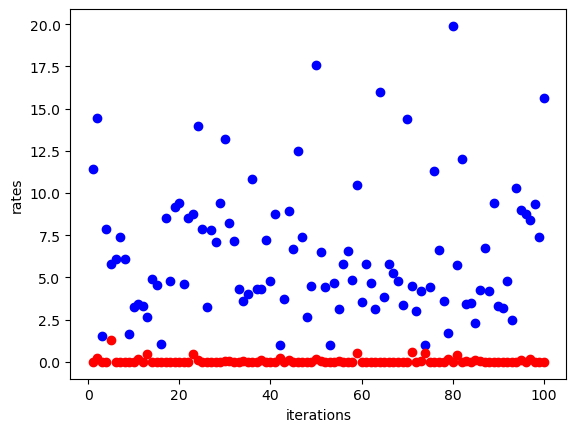

stretched mean =  6.467985621371189 mono mean =  0.06485876134413301
stretched relative error =  0.05916265651805896 mono relative error =  0.27139546794073505


In [15]:
#Run different lattice configurations simultaneously using different CPU cores

from pathos.multiprocessing import ProcessingPool as Pool

import time
start_time = time.time()

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def FCC_lattice(a,size):

        x = a*np.array([1, 0, 0])
        y = a*np.array([0, 1, 0])
        z = a*np.array([0, 0, 1])

        offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

        # List of positions in a single unit cell for FCC structure
        fcc_positions = (a/2)*np.array([
            [0, 0, 0],  # Corner atom
            [1, 1, 0],  # Face center (x-y plane)
            [1, 0, 1],  # Face center (x-z plane)
            [0, 1, 1],  # Face center (y-z plane)
            ])

        R = []
        for l in range(-size, size+1):
            for m in range(-size, size+1):
                for n in range(-size, size+1):
                    for pos in fcc_positions:
                        R.append(l*x + m*y + n*z + pos)
                        R.append(l*x + m*y + n*z + pos + offset)

        return np.array(R)


    def place_specials(size):
        R = FCC_lattice(3.57,size)

        prob_C = 0.1*1e-2
        prob_e = 30*1e-6
        specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
        carbons = random.sample(specials, int(len(R)*prob_C))
        electrons = [pt for pt in specials if pt not in carbons]

        S = np.zeros(R.shape)
        T = np.zeros(R.shape)
        for pos in carbons:
            S[pos,:] = R[pos,:]
        for pos in electrons:
            T[pos,:] = R[pos,:]

        carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
        carbon_pts = np.array(carbon_pts)

        e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
        e_pts = np.array(e_pts)

        return carbon_pts, e_pts



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])



    def calculate_M(carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
        diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances2 = np.linalg.norm(diff2, axis=2)

        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
                r = distances2[carbon,e]
                angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((1/2)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        from scipy.spatial import cKDTree

        threshold = 20
        tree = cKDTree(outside_pts)
        pairs = tree.query_pairs(r=threshold, output_type='ndarray')  # shape: (num_pairs, 2)

        W = np.zeros((N_bulk, N_bulk))
        for i, j in pairs:
            diff = outside_pts[i] - outside_pts[j]
            dist = np.linalg.norm(diff)
            unit_vec = diff / dist
            angle = np.arccos(unit_vec[2])

            A = 1 - 3 * (np.cos(angle))**2
            B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
            W[i, j] = 0.5 * B**2 * tau_d
            W[j, i] = 0.5 * B**2 * tau_d# symmetry

        W = W - np.diag(np.sum(W, axis=0))

        M = W-R
        return N_bulk, M



    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha
    
    def fit_product(P,T):
        from scipy.optimize import curve_fit
        def product_exp(x, a, b):
            return np.exp(-np.sqrt(a*x))*np.exp(-b*x)
        
        popt, pcov = curve_fit(product_exp, T, P, bounds=([0, 0], [1, 1]))
        stretched_rate = popt[0]*1e3
        mono_rate = popt[1]*1e3
        return stretched_rate, mono_rate
        
    tau_p, tau_d = params
    
    size = 12
    T = np.linspace(0,2000,100)
    P = np.zeros(len(T))
    carbon_pts, e_pts = place_specials(size)
    N_bulk, M = calculate_M(carbon_pts, e_pts, tau_p, tau_d)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    stretched_rate, mono_rate = fit_product(P,T)
    return stretched_rate, mono_rate


iterations = 100
inputs = [(9.958e-7, 0.8e-2)] * iterations

pool = Pool()
results = pool.map(run_simulation, inputs)

print(np.array(results).shape)
end_time = time.time()
print(end_time-start_time)

T = np.linspace(1,iterations,iterations)
stretched = np.array(results)[:,0]
mono = np.array(results)[:,1]
fig = plt.figure()
plt.scatter(T, stretched, color='b', label = 'stretched')
plt.scatter(T, mono, color='r', label = 'mono')
plt.xlabel('iterations')
plt.ylabel('rates')
plt.show()

stretched_mean = np.mean(stretched)
mono_mean = np.mean(mono)
stretched_var = (np.sqrt(np.var(stretched)/iterations))/np.mean(stretched)
mono_var = (np.sqrt(np.var(mono)/iterations))/np.mean(mono)
print('stretched mean = ', stretched_mean, 'mono mean = ', mono_mean)
print('stretched relative error = ', stretched_var, 'mono relative error = ', mono_var)

(100, 200)
52.486695766448975


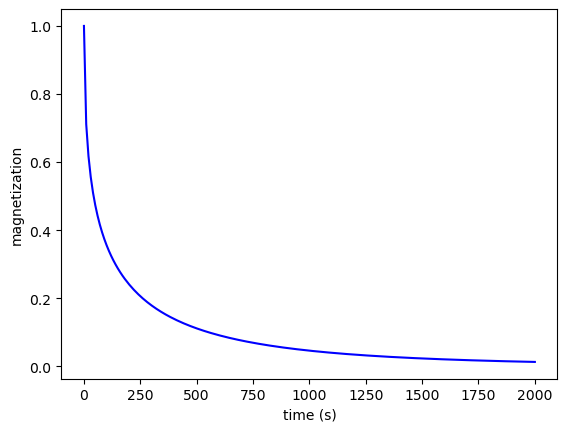

In [10]:
#Run different lattice configurations simultaneously using different CPU cores

from pathos.multiprocessing import ProcessingPool as Pool

import time
start_time = time.time()

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def FCC_lattice(a,size):

        x = a*np.array([1, 0, 0])
        y = a*np.array([0, 1, 0])
        z = a*np.array([0, 0, 1])

        offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

        # List of positions in a single unit cell for FCC structure
        fcc_positions = (a/2)*np.array([
            [0, 0, 0],  # Corner atom
            [1, 1, 0],  # Face center (x-y plane)
            [1, 0, 1],  # Face center (x-z plane)
            [0, 1, 1],  # Face center (y-z plane)
            ])

        R = []
        for l in range(-size, size+1):
            for m in range(-size, size+1):
                for n in range(-size, size+1):
                    for pos in fcc_positions:
                        R.append(l*x + m*y + n*z + pos)
                        R.append(l*x + m*y + n*z + pos + offset)

        return np.array(R)


    def place_specials(size):
        R = FCC_lattice(3.57,size)

        prob_C = 0.2*1e-2
        prob_e = 30*1e-6
        specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
        carbons = random.sample(specials, int(len(R)*prob_C))
        electrons = [pt for pt in specials if pt not in carbons]

        S = np.zeros(R.shape)
        T = np.zeros(R.shape)
        for pos in carbons:
            S[pos,:] = R[pos,:]
        for pos in electrons:
            T[pos,:] = R[pos,:]

        carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
        carbon_pts = np.array(carbon_pts)

        e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
        e_pts = np.array(e_pts)

        return carbon_pts, e_pts



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])



    def calculate_M(carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
        diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances2 = np.linalg.norm(diff2, axis=2)

        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
                r = distances2[carbon,e]
                angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((1/2)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        from scipy.spatial import cKDTree

        threshold = 20
        tree = cKDTree(outside_pts)
        pairs = tree.query_pairs(r=threshold, output_type='ndarray')  # shape: (num_pairs, 2)

        W = np.zeros((N_bulk, N_bulk))
        for i, j in pairs:
            diff = outside_pts[i] - outside_pts[j]
            dist = np.linalg.norm(diff)
            unit_vec = diff / dist
            angle = np.arccos(unit_vec[2])

            A = 1 - 3 * (np.cos(angle))**2
            B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
            W[i, j] = 0.5 * B**2 * tau_d
            W[j, i] = 0.5 * B**2 * tau_d# symmetry

        W = W - np.diag(np.sum(W, axis=0))

        M = W-R
        return N_bulk, M



    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha
    
    
    tau_p, tau_d = params
    
    size = 12
    T = np.linspace(0,2000,200)
    P = np.zeros(len(T))
    carbon_pts, e_pts = place_specials(size)
    N_bulk, M = calculate_M(carbon_pts, e_pts, tau_p, tau_d)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    return P


iterations = 100
inputs = [(1.4e-6, 0.7e-2)] * iterations

pool = Pool()
results = pool.map(run_simulation, inputs)

print(np.array(results).shape)
end_time = time.time()
print(end_time-start_time)

P = np.array(results)
P_avg = (np.sum(P, axis=0))/iterations
T = np.linspace(0,2000,200)
fig = plt.figure()
plt.plot(T, P_avg, color='b')
plt.xlabel('time (s)')
plt.ylabel('magnetization')
plt.show()

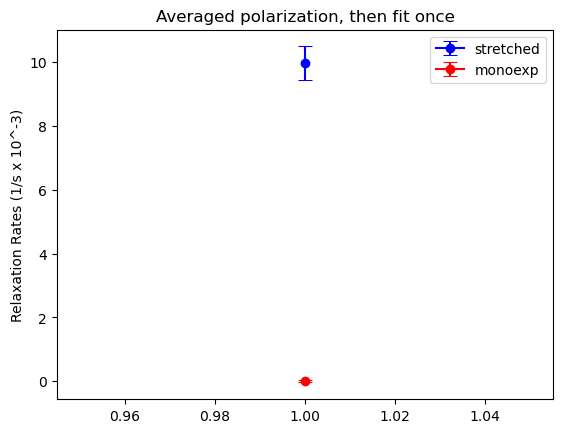

stretched rate = 9.965756251949665 \pm 0.5279680725095663
mono rate = 4.427502275670551e-19 \pm 0.03638019827866268


In [11]:
def fit_product(P,T):
    from scipy.optimize import curve_fit
    def product_exp(x, a, b):
        return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

    popt, pcov = curve_fit(product_exp, T, P, bounds=([0, 0], [1, 1]))
    stretched_rate = popt[0]*1e3
    mono_rate = popt[1]*1e3
    return stretched_rate, mono_rate

stretched_avg, mono_avg = fit_product(P_avg,T)

stretched_rate = np.zeros((iterations))
mono_rate = np.zeros((iterations))

for j in range(iterations):
    stretched_rate[j], mono_rate[j] = fit_product(P[j,:],T)
    
stretched_mean = np.mean(stretched_rate)
mono_mean = np.mean(mono_rate)

stretched_error = (np.sqrt(np.var(stretched_rate)/iterations))
mono_error = (np.sqrt(np.var(mono_rate)/iterations))

fig = plt.figure()
plt.errorbar(1, stretched_avg, stretched_error, fmt='-o', capsize=5, capthick=0.75, color = 'blue', label = 'stretched')
plt.errorbar(1, mono_avg, mono_error, fmt='-o', capsize=5, capthick=0.75, color = 'red', label = 'monoexp') 
plt.title("Averaged polarization, then fit once")
# plt.xlabel("1/tau_c (1/s)")
plt.ylabel("Relaxation Rates (1/s x 10^-3)")
plt.legend()
plt.show()

print("stretched rate =", stretched_avg, "\pm", stretched_error)
print("mono rate =", mono_avg, "\pm", mono_error)

filename = f"0.2%_RelaxationRates.npz"
np.savez(filename, S = stretched_rate, M = mono_rate, S_avg = stretched_avg, M_avg = mono_avg)

# fig.savefig("C:\\Users\\Suber\\Desktop\\Regime1_new.eps", format='eps', dpi=300)

(100, 200)
51.046096324920654


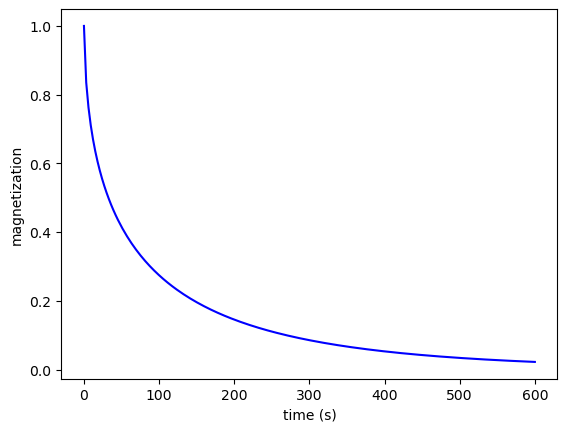

In [12]:
#Run different lattice configurations simultaneously using different CPU cores

from pathos.multiprocessing import ProcessingPool as Pool

import time
start_time = time.time()

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def FCC_lattice(a,size):

        x = a*np.array([1, 0, 0])
        y = a*np.array([0, 1, 0])
        z = a*np.array([0, 0, 1])

        offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

        # List of positions in a single unit cell for FCC structure
        fcc_positions = (a/2)*np.array([
            [0, 0, 0],  # Corner atom
            [1, 1, 0],  # Face center (x-y plane)
            [1, 0, 1],  # Face center (x-z plane)
            [0, 1, 1],  # Face center (y-z plane)
            ])

        R = []
        for l in range(-size, size+1):
            for m in range(-size, size+1):
                for n in range(-size, size+1):
                    for pos in fcc_positions:
                        R.append(l*x + m*y + n*z + pos)
                        R.append(l*x + m*y + n*z + pos + offset)

        return np.array(R)


    def place_specials(size):
        R = FCC_lattice(3.57,size)

        prob_C = 0.5*1e-2
        prob_e = 30*1e-6
        specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
        carbons = random.sample(specials, int(len(R)*prob_C))
        electrons = [pt for pt in specials if pt not in carbons]

        S = np.zeros(R.shape)
        T = np.zeros(R.shape)
        for pos in carbons:
            S[pos,:] = R[pos,:]
        for pos in electrons:
            T[pos,:] = R[pos,:]

        carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
        carbon_pts = np.array(carbon_pts)

        e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
        e_pts = np.array(e_pts)

        return carbon_pts, e_pts



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])



    def calculate_M(carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
        diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances2 = np.linalg.norm(diff2, axis=2)

        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
                r = distances2[carbon,e]
                angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((1/2)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        from scipy.spatial import cKDTree

        threshold = 20
        tree = cKDTree(outside_pts)
        pairs = tree.query_pairs(r=threshold, output_type='ndarray')  # shape: (num_pairs, 2)

        W = np.zeros((N_bulk, N_bulk))
        for i, j in pairs:
            diff = outside_pts[i] - outside_pts[j]
            dist = np.linalg.norm(diff)
            unit_vec = diff / dist
            angle = np.arccos(unit_vec[2])

            A = 1 - 3 * (np.cos(angle))**2
            B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
            W[i, j] = 0.5 * B**2 * tau_d
            W[j, i] = 0.5 * B**2 * tau_d# symmetry

        W = W - np.diag(np.sum(W, axis=0))

        M = W-R
        return N_bulk, M



    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha
    
    
    tau_p, tau_d = params
    
    size = 12
    T = np.linspace(0,600,200)
    P = np.zeros(len(T))
    carbon_pts, e_pts = place_specials(size)
    N_bulk, M = calculate_M(carbon_pts, e_pts, tau_p, tau_d)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    return P


iterations = 100
inputs = [(1.4e-6, 0.7e-2)] * iterations

pool = Pool()
results = pool.map(run_simulation, inputs)

print(np.array(results).shape)
end_time = time.time()
print(end_time-start_time)

P = np.array(results)
P_avg = (np.sum(P, axis=0))/iterations
T = np.linspace(0,600,200)
fig = plt.figure()
plt.plot(T, P_avg, color='b')
plt.xlabel('time (s)')
plt.ylabel('magnetization')
plt.show()

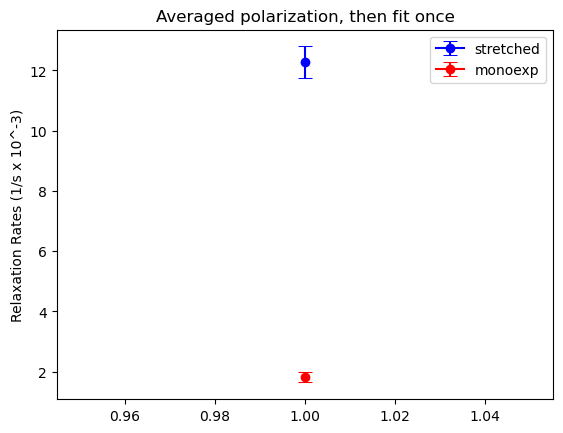

stretched rate = 12.26919013846432 \pm 0.5269679731954992
mono rate = 1.8200413823770742 \pm 0.18174625727120444


In [13]:
def fit_product(P,T):
    from scipy.optimize import curve_fit
    def product_exp(x, a, b):
        return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

    popt, pcov = curve_fit(product_exp, T, P, bounds=([0, 0], [1, 1]))
    stretched_rate = popt[0]*1e3
    mono_rate = popt[1]*1e3
    return stretched_rate, mono_rate

stretched_avg, mono_avg = fit_product(P_avg,T)

stretched_rate = np.zeros((iterations))
mono_rate = np.zeros((iterations))

for j in range(iterations):
    stretched_rate[j], mono_rate[j] = fit_product(P[j,:],T)
    
stretched_mean = np.mean(stretched_rate)
mono_mean = np.mean(mono_rate)

stretched_error = (np.sqrt(np.var(stretched_rate)/iterations))
mono_error = (np.sqrt(np.var(mono_rate)/iterations))

fig = plt.figure()
plt.errorbar(1, stretched_avg, stretched_error, fmt='-o', capsize=5, capthick=0.75, color = 'blue', label = 'stretched')
plt.errorbar(1, mono_avg, mono_error, fmt='-o', capsize=5, capthick=0.75, color = 'red', label = 'monoexp') 
plt.title("Averaged polarization, then fit once")
# plt.xlabel("1/tau_c (1/s)")
plt.ylabel("Relaxation Rates (1/s x 10^-3)")
plt.legend()
plt.show()

print("stretched rate =", stretched_avg, "\pm", stretched_error)
print("mono rate =", mono_avg, "\pm", mono_error)

filename = f"0.5%_RelaxationRates.npz"
np.savez(filename, S = stretched_rate, M = mono_rate, S_avg = stretched_avg, M_avg = mono_avg)

# fig.savefig("C:\\Users\\Suber\\Desktop\\Regime1_new.eps", format='eps', dpi=300)

(100, 100)
71.54159832000732


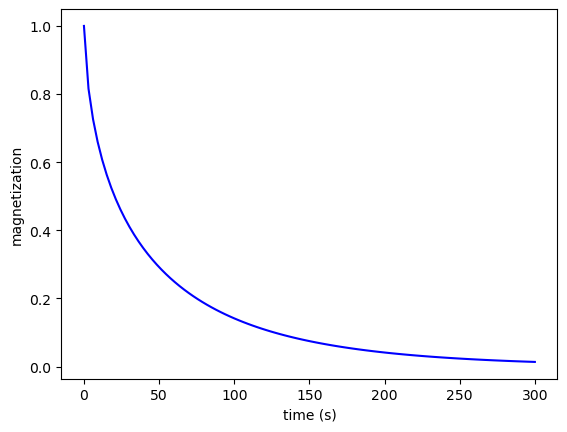

In [14]:
#Run different lattice configurations simultaneously using different CPU cores

from pathos.multiprocessing import ProcessingPool as Pool

import time
start_time = time.time()

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def FCC_lattice(a,size):

        x = a*np.array([1, 0, 0])
        y = a*np.array([0, 1, 0])
        z = a*np.array([0, 0, 1])

        offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

        # List of positions in a single unit cell for FCC structure
        fcc_positions = (a/2)*np.array([
            [0, 0, 0],  # Corner atom
            [1, 1, 0],  # Face center (x-y plane)
            [1, 0, 1],  # Face center (x-z plane)
            [0, 1, 1],  # Face center (y-z plane)
            ])

        R = []
        for l in range(-size, size+1):
            for m in range(-size, size+1):
                for n in range(-size, size+1):
                    for pos in fcc_positions:
                        R.append(l*x + m*y + n*z + pos)
                        R.append(l*x + m*y + n*z + pos + offset)

        return np.array(R)


    def place_specials(size):
        R = FCC_lattice(3.57,size)

        prob_C = 1.1*1e-2
        prob_e = 30*1e-6
        specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
        carbons = random.sample(specials, int(len(R)*prob_C))
        electrons = [pt for pt in specials if pt not in carbons]

        S = np.zeros(R.shape)
        T = np.zeros(R.shape)
        for pos in carbons:
            S[pos,:] = R[pos,:]
        for pos in electrons:
            T[pos,:] = R[pos,:]

        carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
        carbon_pts = np.array(carbon_pts)

        e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
        e_pts = np.array(e_pts)

        return carbon_pts, e_pts



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])



    def calculate_M(carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
        diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances2 = np.linalg.norm(diff2, axis=2)

        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
                r = distances2[carbon,e]
                angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((1/2)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        from scipy.spatial import cKDTree

        threshold = 20
        tree = cKDTree(outside_pts)
        pairs = tree.query_pairs(r=threshold, output_type='ndarray')  # shape: (num_pairs, 2)

        W = np.zeros((N_bulk, N_bulk))
        for i, j in pairs:
            diff = outside_pts[i] - outside_pts[j]
            dist = np.linalg.norm(diff)
            unit_vec = diff / dist
            angle = np.arccos(unit_vec[2])

            A = 1 - 3 * (np.cos(angle))**2
            B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
            W[i, j] = 0.5 * B**2 * tau_d
            W[j, i] = 0.5 * B**2 * tau_d# symmetry

        W = W - np.diag(np.sum(W, axis=0))

        M = W-R
        return N_bulk, M



    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha
    
    
    tau_p, tau_d = params
    
    size = 12
    T = np.linspace(0,300,100)
    P = np.zeros(len(T))
    carbon_pts, e_pts = place_specials(size)
    N_bulk, M = calculate_M(carbon_pts, e_pts, tau_p, tau_d)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    return P


iterations = 100
inputs = [(1.4e-6, 0.7e-2)] * iterations

pool = Pool()
results = pool.map(run_simulation, inputs)

print(np.array(results).shape)
end_time = time.time()
print(end_time-start_time)

P = np.array(results)
P_avg = (np.sum(P, axis=0))/iterations
T = np.linspace(0,300,100)
fig = plt.figure()
plt.plot(T, P_avg, color='b')
plt.xlabel('time (s)')
plt.ylabel('magnetization')
plt.show()

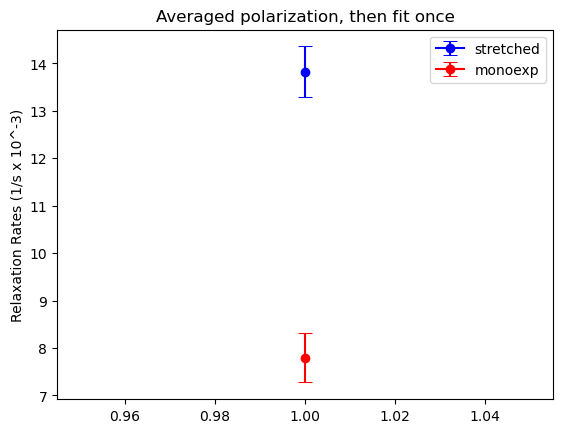

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


stretched rate = 13.822311967307748 \pm 0.5347919954145184
mono rate = 7.798653209797362 \pm 0.5257912936286437


In [15]:
def fit_product(P,T):
    from scipy.optimize import curve_fit
    def product_exp(x, a, b):
        return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

    popt, pcov = curve_fit(product_exp, T, P, bounds=([0, 0], [1, 1]))
    stretched_rate = popt[0]*1e3
    mono_rate = popt[1]*1e3
    return stretched_rate, mono_rate

stretched_avg, mono_avg = fit_product(P_avg,T)

stretched_rate = np.zeros((iterations))
mono_rate = np.zeros((iterations))

for j in range(iterations):
    stretched_rate[j], mono_rate[j] = fit_product(P[j,:],T)
    
stretched_mean = np.mean(stretched_rate)
mono_mean = np.mean(mono_rate)

stretched_error = (np.sqrt(np.var(stretched_rate)/iterations))
mono_error = (np.sqrt(np.var(mono_rate)/iterations))

fig = plt.figure()
plt.errorbar(1, stretched_avg, stretched_error, fmt='-o', capsize=5, capthick=0.75, color = 'blue', label = 'stretched')
plt.errorbar(1, mono_avg, mono_error, fmt='-o', capsize=5, capthick=0.75, color = 'red', label = 'monoexp') 
plt.title("Averaged polarization, then fit once")
# plt.xlabel("1/tau_c (1/s)")
plt.ylabel("Relaxation Rates (1/s x 10^-3)")
plt.legend()
plt.show()

print("stretched rate =", stretched_avg, "\pm", stretched_error)
print("mono rate =", mono_avg, "\pm", mono_error)

filename = f"1.1%_RelaxationRates.npz"
np.savez(filename, S = stretched_rate, M = mono_rate, S_avg = stretched_avg, M_avg = mono_avg)

fig.savefig("C:\\Users\\Suber\\Desktop\\Regime1_new.eps", format='eps', dpi=300)

(100, 100)
774.0795867443085


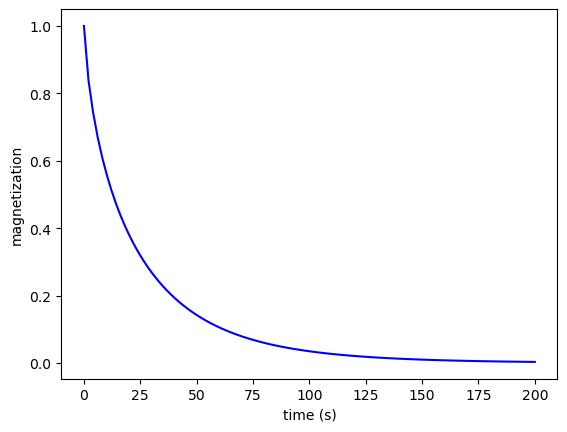

In [16]:
#Run different lattice configurations simultaneously using different CPU cores

from pathos.multiprocessing import ProcessingPool as Pool

import time
start_time = time.time()

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def FCC_lattice(a,size):

        x = a*np.array([1, 0, 0])
        y = a*np.array([0, 1, 0])
        z = a*np.array([0, 0, 1])

        offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

        # List of positions in a single unit cell for FCC structure
        fcc_positions = (a/2)*np.array([
            [0, 0, 0],  # Corner atom
            [1, 1, 0],  # Face center (x-y plane)
            [1, 0, 1],  # Face center (x-z plane)
            [0, 1, 1],  # Face center (y-z plane)
            ])

        R = []
        for l in range(-size, size+1):
            for m in range(-size, size+1):
                for n in range(-size, size+1):
                    for pos in fcc_positions:
                        R.append(l*x + m*y + n*z + pos)
                        R.append(l*x + m*y + n*z + pos + offset)

        return np.array(R)


    def place_specials(size):
        R = FCC_lattice(3.57,size)

        prob_C = 2.5*1e-2
        prob_e = 30*1e-6
        specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
        carbons = random.sample(specials, int(len(R)*prob_C))
        electrons = [pt for pt in specials if pt not in carbons]

        S = np.zeros(R.shape)
        T = np.zeros(R.shape)
        for pos in carbons:
            S[pos,:] = R[pos,:]
        for pos in electrons:
            T[pos,:] = R[pos,:]

        carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
        carbon_pts = np.array(carbon_pts)

        e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
        e_pts = np.array(e_pts)

        return carbon_pts, e_pts



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])



    def calculate_M(carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
        diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances2 = np.linalg.norm(diff2, axis=2)

        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
                r = distances2[carbon,e]
                angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((1/2)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        from scipy.spatial import cKDTree

        threshold = 20
        tree = cKDTree(outside_pts)
        pairs = tree.query_pairs(r=threshold, output_type='ndarray')  # shape: (num_pairs, 2)

        W = np.zeros((N_bulk, N_bulk))
        for i, j in pairs:
            diff = outside_pts[i] - outside_pts[j]
            dist = np.linalg.norm(diff)
            unit_vec = diff / dist
            angle = np.arccos(unit_vec[2])

            A = 1 - 3 * (np.cos(angle))**2
            B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
            W[i, j] = 0.5 * B**2 * tau_d
            W[j, i] = 0.5 * B**2 * tau_d# symmetry

        W = W - np.diag(np.sum(W, axis=0))

        M = W-R
        return N_bulk, M



    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha
    
    
    tau_p, tau_d = params
    
    size = 12
    T = np.linspace(0,200,100)
    P = np.zeros(len(T))
    carbon_pts, e_pts = place_specials(size)
    N_bulk, M = calculate_M(carbon_pts, e_pts, tau_p, tau_d)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    return P


iterations = 100
inputs = [(1.4e-6, 0.7e-2)] * iterations

pool = Pool()
results = pool.map(run_simulation, inputs)

print(np.array(results).shape)
end_time = time.time()
print(end_time-start_time)

P = np.array(results)
P_avg = (np.sum(P, axis=0))/iterations
T = np.linspace(0,200,100)
fig = plt.figure()
plt.plot(T, P_avg, color='b')
plt.xlabel('time (s)')
plt.ylabel('magnetization')
plt.show()

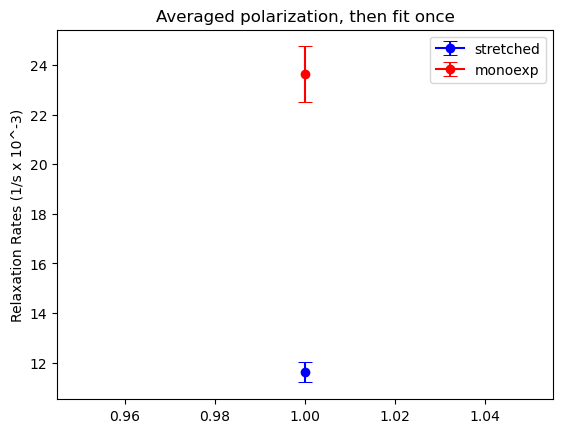

stretched rate = 11.61325209936601 \pm 0.4071227658193342
mono rate = 23.62190494913996 \pm 1.1188131700073505


In [17]:
def fit_product(P,T):
    from scipy.optimize import curve_fit
    def product_exp(x, a, b):
        return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

    popt, pcov = curve_fit(product_exp, T, P, bounds=([0, 0], [1, 1]))
    stretched_rate = popt[0]*1e3
    mono_rate = popt[1]*1e3
    return stretched_rate, mono_rate

stretched_avg, mono_avg = fit_product(P_avg,T)

stretched_rate = np.zeros((iterations))
mono_rate = np.zeros((iterations))

for j in range(iterations):
    stretched_rate[j], mono_rate[j] = fit_product(P[j,:],T)
    
stretched_mean = np.mean(stretched_rate)
mono_mean = np.mean(mono_rate)

stretched_error = (np.sqrt(np.var(stretched_rate)/iterations))
mono_error = (np.sqrt(np.var(mono_rate)/iterations))

fig = plt.figure()
plt.errorbar(1, stretched_avg, stretched_error, fmt='-o', capsize=5, capthick=0.75, color = 'blue', label = 'stretched')
plt.errorbar(1, mono_avg, mono_error, fmt='-o', capsize=5, capthick=0.75, color = 'red', label = 'monoexp') 
plt.title("Averaged polarization, then fit once")
# plt.xlabel("1/tau_c (1/s)")
plt.ylabel("Relaxation Rates (1/s x 10^-3)")
plt.legend()
plt.show()

print("stretched rate =", stretched_avg, "\pm", stretched_error)
print("mono rate =", mono_avg, "\pm", mono_error)

filename = f"2.5%_RelaxationRates.npz"
np.savez(filename, S = stretched_rate, M = mono_rate, S_avg = stretched_avg, M_avg = mono_avg)

# fig.savefig("C:\\Users\\Suber\\Desktop\\Regime1_new.eps", format='eps', dpi=300)

(100, 100)
1902.4587302207947


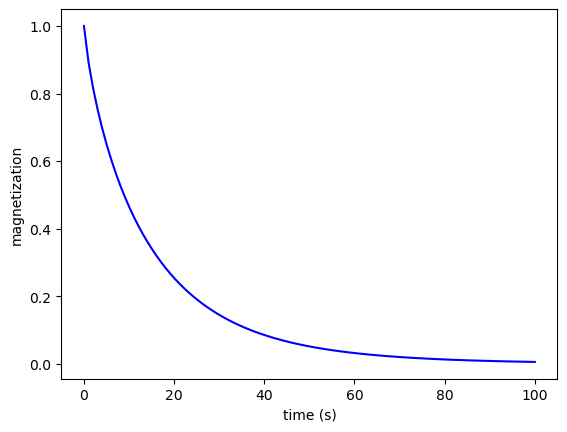

In [18]:
#Run different lattice configurations simultaneously using different CPU cores

from pathos.multiprocessing import ProcessingPool as Pool

import time
start_time = time.time()

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def FCC_lattice(a,size):

        x = a*np.array([1, 0, 0])
        y = a*np.array([0, 1, 0])
        z = a*np.array([0, 0, 1])

        offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

        # List of positions in a single unit cell for FCC structure
        fcc_positions = (a/2)*np.array([
            [0, 0, 0],  # Corner atom
            [1, 1, 0],  # Face center (x-y plane)
            [1, 0, 1],  # Face center (x-z plane)
            [0, 1, 1],  # Face center (y-z plane)
            ])

        R = []
        for l in range(-size, size+1):
            for m in range(-size, size+1):
                for n in range(-size, size+1):
                    for pos in fcc_positions:
                        R.append(l*x + m*y + n*z + pos)
                        R.append(l*x + m*y + n*z + pos + offset)

        return np.array(R)


    def place_specials(size):
        R = FCC_lattice(3.57,size)

        prob_C = 5*1e-2
        prob_e = 30*1e-6
        specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
        carbons = random.sample(specials, int(len(R)*prob_C))
        electrons = [pt for pt in specials if pt not in carbons]

        S = np.zeros(R.shape)
        T = np.zeros(R.shape)
        for pos in carbons:
            S[pos,:] = R[pos,:]
        for pos in electrons:
            T[pos,:] = R[pos,:]

        carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
        carbon_pts = np.array(carbon_pts)

        e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
        e_pts = np.array(e_pts)

        return carbon_pts, e_pts



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])



    def calculate_M(carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
        diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances2 = np.linalg.norm(diff2, axis=2)

        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
                r = distances2[carbon,e]
                angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((1/2)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        from scipy.spatial import cKDTree

        threshold = 20
        tree = cKDTree(outside_pts)
        pairs = tree.query_pairs(r=threshold, output_type='ndarray')  # shape: (num_pairs, 2)

        W = np.zeros((N_bulk, N_bulk))
        for i, j in pairs:
            diff = outside_pts[i] - outside_pts[j]
            dist = np.linalg.norm(diff)
            unit_vec = diff / dist
            angle = np.arccos(unit_vec[2])

            A = 1 - 3 * (np.cos(angle))**2
            B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
            W[i, j] = 0.5 * B**2 * tau_d
            W[j, i] = 0.5 * B**2 * tau_d# symmetry

        W = W - np.diag(np.sum(W, axis=0))

        M = W-R
        return N_bulk, M



    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha
    
    
    tau_p, tau_d = params
    
    size = 12
    T = np.linspace(0,100,100)
    P = np.zeros(len(T))
    carbon_pts, e_pts = place_specials(size)
    N_bulk, M = calculate_M(carbon_pts, e_pts, tau_p, tau_d)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    return P


iterations = 100
inputs = [(1.4e-6, 0.7e-2)] * iterations

pool = Pool()
results = pool.map(run_simulation, inputs)

print(np.array(results).shape)
end_time = time.time()
print(end_time-start_time)

P = np.array(results)
P_avg = (np.sum(P, axis=0))/iterations
T = np.linspace(0,100,100)
fig = plt.figure()
plt.plot(T, P_avg, color='b')
plt.xlabel('time (s)')
plt.ylabel('magnetization')
plt.show()

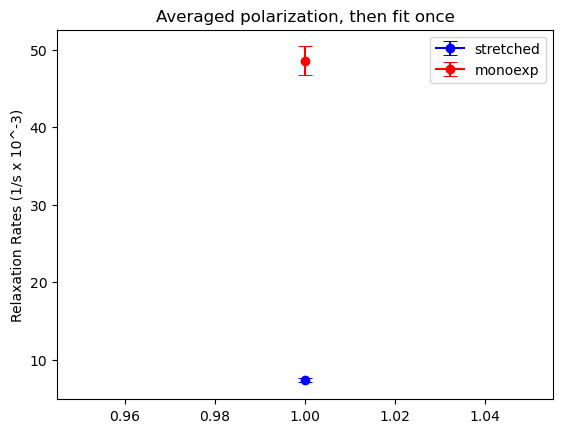

stretched rate = 7.346098863521372 \pm 0.2750858720850787
mono rate = 48.549075446563165 \pm 1.8703078971599012


In [19]:
def fit_product(P,T):
    from scipy.optimize import curve_fit
    def product_exp(x, a, b):
        return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

    popt, pcov = curve_fit(product_exp, T, P, bounds=([0, 0], [1, 1]))
    stretched_rate = popt[0]*1e3
    mono_rate = popt[1]*1e3
    return stretched_rate, mono_rate

stretched_avg, mono_avg = fit_product(P_avg,T)

stretched_rate = np.zeros((iterations))
mono_rate = np.zeros((iterations))

for j in range(iterations):
    stretched_rate[j], mono_rate[j] = fit_product(P[j,:],T)
    
stretched_mean = np.mean(stretched_rate)
mono_mean = np.mean(mono_rate)

stretched_error = (np.sqrt(np.var(stretched_rate)/iterations))
mono_error = (np.sqrt(np.var(mono_rate)/iterations))

fig = plt.figure()
plt.errorbar(1, stretched_avg, stretched_error, fmt='-o', capsize=5, capthick=0.75, color = 'blue', label = 'stretched')
plt.errorbar(1, mono_avg, mono_error, fmt='-o', capsize=5, capthick=0.75, color = 'red', label = 'monoexp') 
plt.title("Averaged polarization, then fit once")
# plt.xlabel("1/tau_c (1/s)")
plt.ylabel("Relaxation Rates (1/s x 10^-3)")
plt.legend()
plt.show()

print("stretched rate =", stretched_avg, "\pm", stretched_error)
print("mono rate =", mono_avg, "\pm", mono_error)

filename = f"5%_RelaxationRates.npz"
np.savez(filename, S = stretched_rate, M = mono_rate, S_avg = stretched_avg, M_avg = mono_avg)

# fig.savefig("C:\\Users\\Suber\\Desktop\\Regime1_new.eps", format='eps', dpi=300)

(100, 100)
5097.457470655441


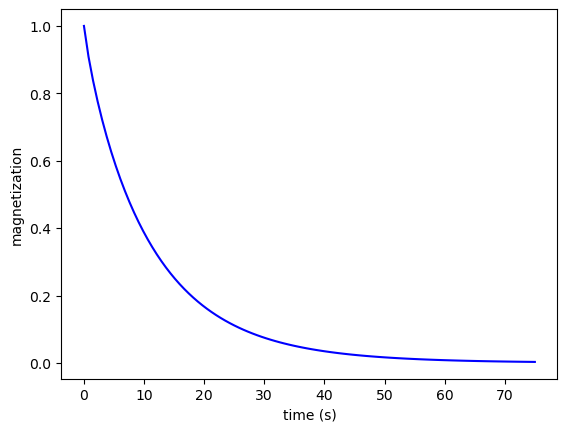

In [20]:
#Run different lattice configurations simultaneously using different CPU cores

from pathos.multiprocessing import ProcessingPool as Pool

import time
start_time = time.time()

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def FCC_lattice(a,size):

        x = a*np.array([1, 0, 0])
        y = a*np.array([0, 1, 0])
        z = a*np.array([0, 0, 1])

        offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

        # List of positions in a single unit cell for FCC structure
        fcc_positions = (a/2)*np.array([
            [0, 0, 0],  # Corner atom
            [1, 1, 0],  # Face center (x-y plane)
            [1, 0, 1],  # Face center (x-z plane)
            [0, 1, 1],  # Face center (y-z plane)
            ])

        R = []
        for l in range(-size, size+1):
            for m in range(-size, size+1):
                for n in range(-size, size+1):
                    for pos in fcc_positions:
                        R.append(l*x + m*y + n*z + pos)
                        R.append(l*x + m*y + n*z + pos + offset)

        return np.array(R)


    def place_specials(size):
        R = FCC_lattice(3.57,size)

        prob_C = 7.5*1e-2
        prob_e = 30*1e-6
        specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
        carbons = random.sample(specials, int(len(R)*prob_C))
        electrons = [pt for pt in specials if pt not in carbons]

        S = np.zeros(R.shape)
        T = np.zeros(R.shape)
        for pos in carbons:
            S[pos,:] = R[pos,:]
        for pos in electrons:
            T[pos,:] = R[pos,:]

        carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
        carbon_pts = np.array(carbon_pts)

        e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
        e_pts = np.array(e_pts)

        return carbon_pts, e_pts



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])



    def calculate_M(carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
        diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances2 = np.linalg.norm(diff2, axis=2)

        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
                r = distances2[carbon,e]
                angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((1/2)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        from scipy.spatial import cKDTree

        threshold = 20
        tree = cKDTree(outside_pts)
        pairs = tree.query_pairs(r=threshold, output_type='ndarray')  # shape: (num_pairs, 2)

        W = np.zeros((N_bulk, N_bulk))
        for i, j in pairs:
            diff = outside_pts[i] - outside_pts[j]
            dist = np.linalg.norm(diff)
            unit_vec = diff / dist
            angle = np.arccos(unit_vec[2])

            A = 1 - 3 * (np.cos(angle))**2
            B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
            W[i, j] = 0.5 * B**2 * tau_d
            W[j, i] = 0.5 * B**2 * tau_d# symmetry

        W = W - np.diag(np.sum(W, axis=0))

        M = W-R
        return N_bulk, M



    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha
    
    
    tau_p, tau_d = params
    
    size = 12
    T = np.linspace(0,75,100)
    P = np.zeros(len(T))
    carbon_pts, e_pts = place_specials(size)
    N_bulk, M = calculate_M(carbon_pts, e_pts, tau_p, tau_d)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    return P


iterations = 100
inputs = [(1.4e-6, 0.7e-2)] * iterations

pool = Pool(nodes=4)
results = pool.map(run_simulation, inputs)

print(np.array(results).shape)
end_time = time.time()
print(end_time-start_time)

P = np.array(results)
P_avg = (np.sum(P, axis=0))/iterations
T = np.linspace(0,75,100)
fig = plt.figure()
plt.plot(T, P_avg, color='b')
plt.xlabel('time (s)')
plt.ylabel('magnetization')
plt.show()

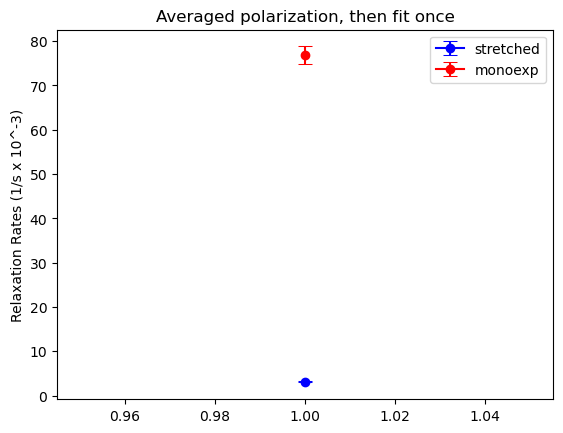

stretched rate = 3.1072456039164766 \pm 0.13931857124053462
mono rate = 76.86062423814617 \pm 1.9303066014119865


In [21]:
def fit_product(P,T):
    from scipy.optimize import curve_fit
    def product_exp(x, a, b):
        return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

    popt, pcov = curve_fit(product_exp, T, P, bounds=([0, 0], [1, 1]))
    stretched_rate = popt[0]*1e3
    mono_rate = popt[1]*1e3
    return stretched_rate, mono_rate

stretched_avg, mono_avg = fit_product(P_avg,T)

stretched_rate = np.zeros((iterations))
mono_rate = np.zeros((iterations))

for j in range(iterations):
    stretched_rate[j], mono_rate[j] = fit_product(P[j,:],T)
    
stretched_mean = np.mean(stretched_rate)
mono_mean = np.mean(mono_rate)

stretched_error = (np.sqrt(np.var(stretched_rate)/iterations))
mono_error = (np.sqrt(np.var(mono_rate)/iterations))

fig = plt.figure()
plt.errorbar(1, stretched_avg, stretched_error, fmt='-o', capsize=5, capthick=0.75, color = 'blue', label = 'stretched')
plt.errorbar(1, mono_avg, mono_error, fmt='-o', capsize=5, capthick=0.75, color = 'red', label = 'monoexp') 
plt.title("Averaged polarization, then fit once")
# plt.xlabel("1/tau_c (1/s)")
plt.ylabel("Relaxation Rates (1/s x 10^-3)")
plt.legend()
plt.show()

print("stretched rate =", stretched_avg, "\pm", stretched_error)
print("mono rate =", mono_avg, "\pm", mono_error)

filename = f"7.5%_RelaxationRates.npz"
np.savez(filename, S = stretched_rate, M = mono_rate, S_avg = stretched_avg, M_avg = mono_avg)

# fig.savefig("C:\\Users\\Suber\\Desktop\\Regime1_new.eps", format='eps', dpi=300)

(100, 100)
12283.387053251266


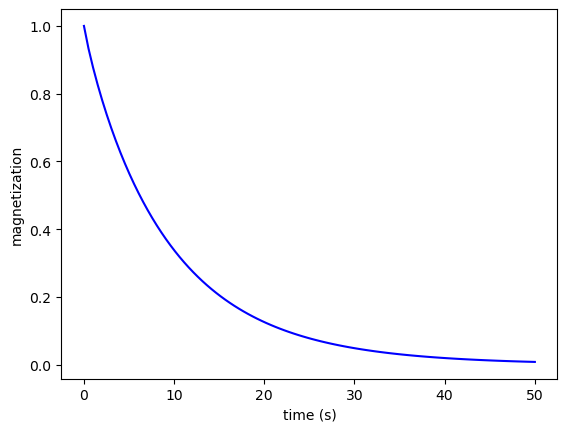

In [22]:
#Run different lattice configurations simultaneously using different CPU cores

from pathos.multiprocessing import ProcessingPool as Pool

import time
start_time = time.time()

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def FCC_lattice(a,size):

        x = a*np.array([1, 0, 0])
        y = a*np.array([0, 1, 0])
        z = a*np.array([0, 0, 1])

        offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

        # List of positions in a single unit cell for FCC structure
        fcc_positions = (a/2)*np.array([
            [0, 0, 0],  # Corner atom
            [1, 1, 0],  # Face center (x-y plane)
            [1, 0, 1],  # Face center (x-z plane)
            [0, 1, 1],  # Face center (y-z plane)
            ])

        R = []
        for l in range(-size, size+1):
            for m in range(-size, size+1):
                for n in range(-size, size+1):
                    for pos in fcc_positions:
                        R.append(l*x + m*y + n*z + pos)
                        R.append(l*x + m*y + n*z + pos + offset)

        return np.array(R)


    def place_specials(size):
        R = FCC_lattice(3.57,size)

        prob_C = 10*1e-2
        prob_e = 30*1e-6
        specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
        carbons = random.sample(specials, int(len(R)*prob_C))
        electrons = [pt for pt in specials if pt not in carbons]

        S = np.zeros(R.shape)
        T = np.zeros(R.shape)
        for pos in carbons:
            S[pos,:] = R[pos,:]
        for pos in electrons:
            T[pos,:] = R[pos,:]

        carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
        carbon_pts = np.array(carbon_pts)

        e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
        e_pts = np.array(e_pts)

        return carbon_pts, e_pts



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])



    def calculate_M(carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
        diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances2 = np.linalg.norm(diff2, axis=2)

        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
                r = distances2[carbon,e]
                angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((1/2)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        from scipy.spatial import cKDTree

        threshold = 20
        tree = cKDTree(outside_pts)
        pairs = tree.query_pairs(r=threshold, output_type='ndarray')  # shape: (num_pairs, 2)

        W = np.zeros((N_bulk, N_bulk))
        for i, j in pairs:
            diff = outside_pts[i] - outside_pts[j]
            dist = np.linalg.norm(diff)
            unit_vec = diff / dist
            angle = np.arccos(unit_vec[2])

            A = 1 - 3 * (np.cos(angle))**2
            B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
            W[i, j] = 0.5 * B**2 * tau_d
            W[j, i] = 0.5 * B**2 * tau_d# symmetry

        W = W - np.diag(np.sum(W, axis=0))

        M = W-R
        return N_bulk, M



    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha
    
    
    tau_p, tau_d = params
    
    size = 12
    T = np.linspace(0,50,100)
    P = np.zeros(len(T))
    carbon_pts, e_pts = place_specials(size)
    N_bulk, M = calculate_M(carbon_pts, e_pts, tau_p, tau_d)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    return P


iterations = 100
inputs = [(1.4e-6, 0.7e-2)] * iterations

pool = Pool(nodes=2)
results = pool.map(run_simulation, inputs)

print(np.array(results).shape)
end_time = time.time()
print(end_time-start_time)

P = np.array(results)
P_avg = (np.sum(P, axis=0))/iterations
T = np.linspace(0,50,100)
fig = plt.figure()
plt.plot(T, P_avg, color='b')
plt.xlabel('time (s)')
plt.ylabel('magnetization')
plt.show()

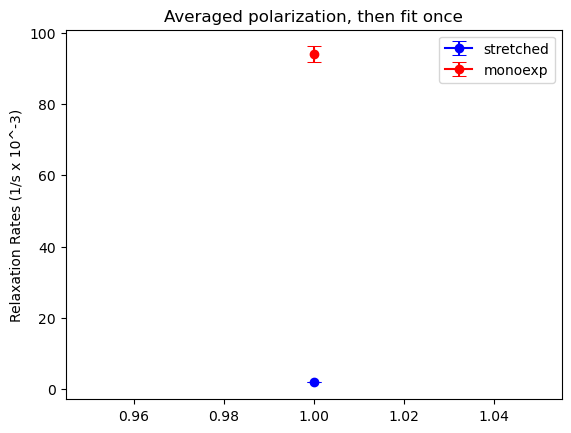

stretched rate = 1.880543491806568 \pm 0.07954435896965645
mono rate = 94.09120671743399 \pm 2.115813280170734


In [23]:
def fit_product(P,T):
    from scipy.optimize import curve_fit
    def product_exp(x, a, b):
        return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

    popt, pcov = curve_fit(product_exp, T, P, bounds=([0, 0], [1, 1]))
    stretched_rate = popt[0]*1e3
    mono_rate = popt[1]*1e3
    return stretched_rate, mono_rate

stretched_avg, mono_avg = fit_product(P_avg,T)

stretched_rate = np.zeros((iterations))
mono_rate = np.zeros((iterations))

for j in range(iterations):
    stretched_rate[j], mono_rate[j] = fit_product(P[j,:],T)
    
stretched_mean = np.mean(stretched_rate)
mono_mean = np.mean(mono_rate)

stretched_error = (np.sqrt(np.var(stretched_rate)/iterations))
mono_error = (np.sqrt(np.var(mono_rate)/iterations))

fig = plt.figure()
plt.errorbar(1, stretched_avg, stretched_error, fmt='-o', capsize=5, capthick=0.75, color = 'blue', label = 'stretched')
plt.errorbar(1, mono_avg, mono_error, fmt='-o', capsize=5, capthick=0.75, color = 'red', label = 'monoexp') 
plt.title("Averaged polarization, then fit once")
# plt.xlabel("1/tau_c (1/s)")
plt.ylabel("Relaxation Rates (1/s x 10^-3)")
plt.legend()
plt.show()

print("stretched rate =", stretched_avg, "\pm", stretched_error)
print("mono rate =", mono_avg, "\pm", mono_error)

filename = f"10%_RelaxationRates.npz"
np.savez(filename, S = stretched_rate, M = mono_rate, S_avg = stretched_avg, M_avg = mono_avg)

# fig.savefig("C:\\Users\\Suber\\Desktop\\Regime1_new.eps", format='eps', dpi=300)

(100, 100)
23098.369252204895


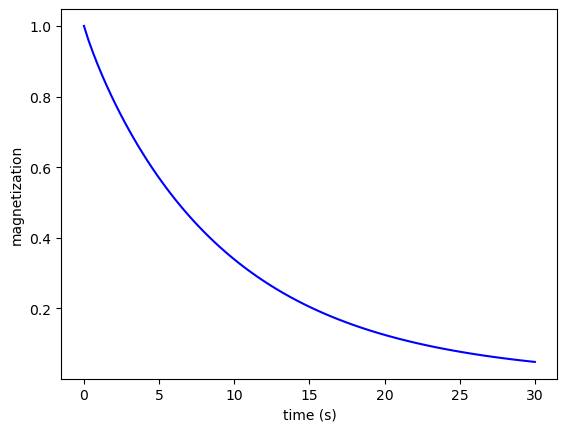

In [24]:
#Run different lattice configurations simultaneously using different CPU cores

from pathos.multiprocessing import ProcessingPool as Pool

import time
start_time = time.time()

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def FCC_lattice(a,size):

        x = a*np.array([1, 0, 0])
        y = a*np.array([0, 1, 0])
        z = a*np.array([0, 0, 1])

        offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

        # List of positions in a single unit cell for FCC structure
        fcc_positions = (a/2)*np.array([
            [0, 0, 0],  # Corner atom
            [1, 1, 0],  # Face center (x-y plane)
            [1, 0, 1],  # Face center (x-z plane)
            [0, 1, 1],  # Face center (y-z plane)
            ])

        R = []
        for l in range(-size, size+1):
            for m in range(-size, size+1):
                for n in range(-size, size+1):
                    for pos in fcc_positions:
                        R.append(l*x + m*y + n*z + pos)
                        R.append(l*x + m*y + n*z + pos + offset)

        return np.array(R)


    def place_specials(size):
        R = FCC_lattice(3.57,size)

        prob_C = 12.5*1e-2
        prob_e = 30*1e-6
        specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
        carbons = random.sample(specials, int(len(R)*prob_C))
        electrons = [pt for pt in specials if pt not in carbons]

        S = np.zeros(R.shape)
        T = np.zeros(R.shape)
        for pos in carbons:
            S[pos,:] = R[pos,:]
        for pos in electrons:
            T[pos,:] = R[pos,:]

        carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
        carbon_pts = np.array(carbon_pts)

        e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
        e_pts = np.array(e_pts)

        return carbon_pts, e_pts



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])



    def calculate_M(carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
        diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances2 = np.linalg.norm(diff2, axis=2)

        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
                r = distances2[carbon,e]
                angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((1/2)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        from scipy.spatial import cKDTree

        threshold = 20
        tree = cKDTree(outside_pts)
        pairs = tree.query_pairs(r=threshold, output_type='ndarray')  # shape: (num_pairs, 2)

        W = np.zeros((N_bulk, N_bulk))
        for i, j in pairs:
            diff = outside_pts[i] - outside_pts[j]
            dist = np.linalg.norm(diff)
            unit_vec = diff / dist
            angle = np.arccos(unit_vec[2])

            A = 1 - 3 * (np.cos(angle))**2
            B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
            W[i, j] = 0.5 * B**2 * tau_d
            W[j, i] = 0.5 * B**2 * tau_d# symmetry

        W = W - np.diag(np.sum(W, axis=0))

        M = W-R
        return N_bulk, M



    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha
    
    
    tau_p, tau_d = params
    
    size = 12
    T = np.linspace(0,30,100)
    P = np.zeros(len(T))
    carbon_pts, e_pts = place_specials(size)
    N_bulk, M = calculate_M(carbon_pts, e_pts, tau_p, tau_d)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    return P


iterations = 100
inputs = [(1.4e-6, 0.7e-2)] * iterations

pool = Pool(nodes=2)
results = pool.map(run_simulation, inputs)

print(np.array(results).shape)
end_time = time.time()
print(end_time-start_time)

P = np.array(results)
P_avg = (np.sum(P, axis=0))/iterations
T = np.linspace(0,30,100)
fig = plt.figure()
plt.plot(T, P_avg, color='b')
plt.xlabel('time (s)')
plt.ylabel('magnetization')
plt.show()

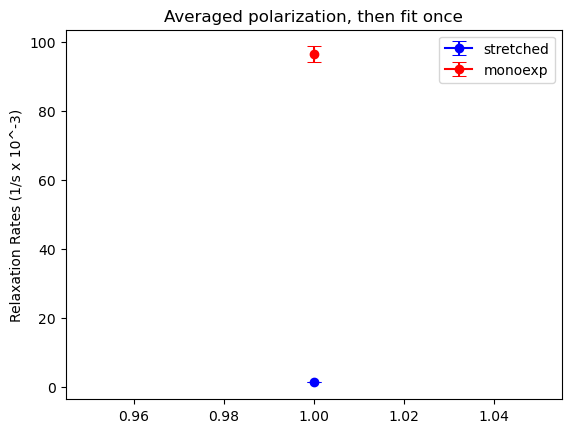

stretched rate = 1.2616960348024904 \pm 0.042928809263008356
mono rate = 96.40179195505398 \pm 2.2808841029217444


In [25]:
def fit_product(P,T):
    from scipy.optimize import curve_fit
    def product_exp(x, a, b):
        return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

    popt, pcov = curve_fit(product_exp, T, P, bounds=([0, 0], [1, 1]))
    stretched_rate = popt[0]*1e3
    mono_rate = popt[1]*1e3
    return stretched_rate, mono_rate

stretched_avg, mono_avg = fit_product(P_avg,T)

stretched_rate = np.zeros((iterations))
mono_rate = np.zeros((iterations))

for j in range(iterations):
    stretched_rate[j], mono_rate[j] = fit_product(P[j,:],T)
    
stretched_mean = np.mean(stretched_rate)
mono_mean = np.mean(mono_rate)

stretched_error = (np.sqrt(np.var(stretched_rate)/iterations))
mono_error = (np.sqrt(np.var(mono_rate)/iterations))

fig = plt.figure()
plt.errorbar(1, stretched_avg, stretched_error, fmt='-o', capsize=5, capthick=0.75, color = 'blue', label = 'stretched')
plt.errorbar(1, mono_avg, mono_error, fmt='-o', capsize=5, capthick=0.75, color = 'red', label = 'monoexp') 
plt.title("Averaged polarization, then fit once")
# plt.xlabel("1/tau_c (1/s)")
plt.ylabel("Relaxation Rates (1/s x 10^-3)")
plt.legend()
plt.show()

print("stretched rate =", stretched_avg, "\pm", stretched_error)
print("mono rate =", mono_avg, "\pm", mono_error)

filename = f"12.5%_RelaxationRates.npz"
np.savez(filename, S = stretched_rate, M = mono_rate, S_avg = stretched_avg, M_avg = mono_avg)

# fig.savefig("C:\\Users\\Suber\\Desktop\\Regime1_new.eps", format='eps', dpi=300)

(100, 100)
223.20400524139404


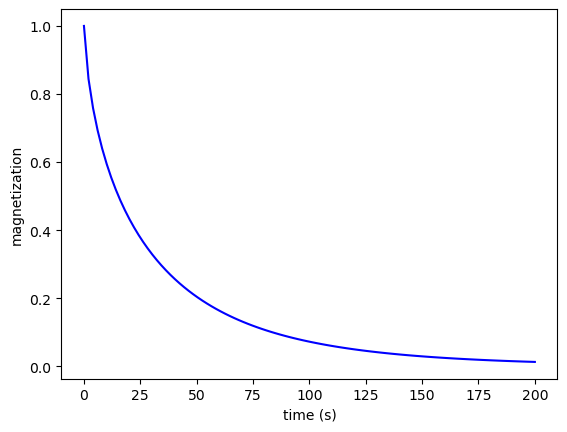

In [26]:
#Run different lattice configurations simultaneously using different CPU cores

from pathos.multiprocessing import ProcessingPool as Pool

import time
start_time = time.time()

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def FCC_lattice(a,size):

        x = a*np.array([1, 0, 0])
        y = a*np.array([0, 1, 0])
        z = a*np.array([0, 0, 1])

        offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

        # List of positions in a single unit cell for FCC structure
        fcc_positions = (a/2)*np.array([
            [0, 0, 0],  # Corner atom
            [1, 1, 0],  # Face center (x-y plane)
            [1, 0, 1],  # Face center (x-z plane)
            [0, 1, 1],  # Face center (y-z plane)
            ])

        R = []
        for l in range(-size, size+1):
            for m in range(-size, size+1):
                for n in range(-size, size+1):
                    for pos in fcc_positions:
                        R.append(l*x + m*y + n*z + pos)
                        R.append(l*x + m*y + n*z + pos + offset)

        return np.array(R)


    def place_specials(size):
        R = FCC_lattice(3.57,size)

        prob_C = 1.75*1e-2
        prob_e = 30*1e-6
        specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
        carbons = random.sample(specials, int(len(R)*prob_C))
        electrons = [pt for pt in specials if pt not in carbons]

        S = np.zeros(R.shape)
        T = np.zeros(R.shape)
        for pos in carbons:
            S[pos,:] = R[pos,:]
        for pos in electrons:
            T[pos,:] = R[pos,:]

        carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
        carbon_pts = np.array(carbon_pts)

        e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
        e_pts = np.array(e_pts)

        return carbon_pts, e_pts



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])



    def calculate_M(carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
        diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances2 = np.linalg.norm(diff2, axis=2)

        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
                r = distances2[carbon,e]
                angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((1/2)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        from scipy.spatial import cKDTree

        threshold = 20
        tree = cKDTree(outside_pts)
        pairs = tree.query_pairs(r=threshold, output_type='ndarray')  # shape: (num_pairs, 2)

        W = np.zeros((N_bulk, N_bulk))
        for i, j in pairs:
            diff = outside_pts[i] - outside_pts[j]
            dist = np.linalg.norm(diff)
            unit_vec = diff / dist
            angle = np.arccos(unit_vec[2])

            A = 1 - 3 * (np.cos(angle))**2
            B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
            W[i, j] = 0.5 * B**2 * tau_d
            W[j, i] = 0.5 * B**2 * tau_d# symmetry

        W = W - np.diag(np.sum(W, axis=0))

        M = W-R
        return N_bulk, M



    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha
    
    
    tau_p, tau_d = params
    
    size = 12
    T = np.linspace(0,200,100)
    P = np.zeros(len(T))
    carbon_pts, e_pts = place_specials(size)
    N_bulk, M = calculate_M(carbon_pts, e_pts, tau_p, tau_d)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    return P


iterations = 100
inputs = [(1.4e-6, 0.7e-2)] * iterations

pool = Pool()
results = pool.map(run_simulation, inputs)

print(np.array(results).shape)
end_time = time.time()
print(end_time-start_time)

P = np.array(results)
P_avg = (np.sum(P, axis=0))/iterations
T = np.linspace(0,200,100)
fig = plt.figure()
plt.plot(T, P_avg, color='b')
plt.xlabel('time (s)')
plt.ylabel('magnetization')
plt.show()

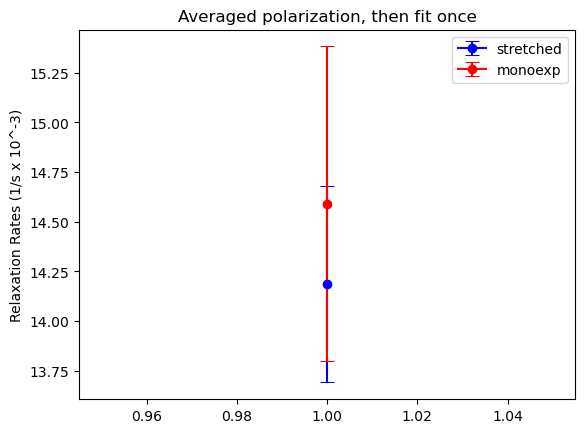

stretched rate = 14.184869396430203 \pm 0.494377294319156
mono rate = 14.589417176313013 \pm 0.7929181658347993


In [27]:
def fit_product(P,T):
    from scipy.optimize import curve_fit
    def product_exp(x, a, b):
        return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

    popt, pcov = curve_fit(product_exp, T, P, bounds=([0, 0], [1, 1]))
    stretched_rate = popt[0]*1e3
    mono_rate = popt[1]*1e3
    return stretched_rate, mono_rate

stretched_avg, mono_avg = fit_product(P_avg,T)

stretched_rate = np.zeros((iterations))
mono_rate = np.zeros((iterations))

for j in range(iterations):
    stretched_rate[j], mono_rate[j] = fit_product(P[j,:],T)
    
stretched_mean = np.mean(stretched_rate)
mono_mean = np.mean(mono_rate)

stretched_error = (np.sqrt(np.var(stretched_rate)/iterations))
mono_error = (np.sqrt(np.var(mono_rate)/iterations))

fig = plt.figure()
plt.errorbar(1, stretched_avg, stretched_error, fmt='-o', capsize=5, capthick=0.75, color = 'blue', label = 'stretched')
plt.errorbar(1, mono_avg, mono_error, fmt='-o', capsize=5, capthick=0.75, color = 'red', label = 'monoexp') 
plt.title("Averaged polarization, then fit once")
# plt.xlabel("1/tau_c (1/s)")
plt.ylabel("Relaxation Rates (1/s x 10^-3)")
plt.legend()
plt.show()

print("stretched rate =", stretched_avg, "\pm", stretched_error)
print("mono rate =", mono_avg, "\pm", mono_error)

filename = f"1.75%_RelaxationRates.npz"
np.savez(filename, S = stretched_rate, M = mono_rate, S_avg = stretched_avg, M_avg = mono_avg)

# fig.savefig("C:\\Users\\Suber\\Desktop\\Regime1_new.eps", format='eps', dpi=300)

(100, 100)
859.1598153114319


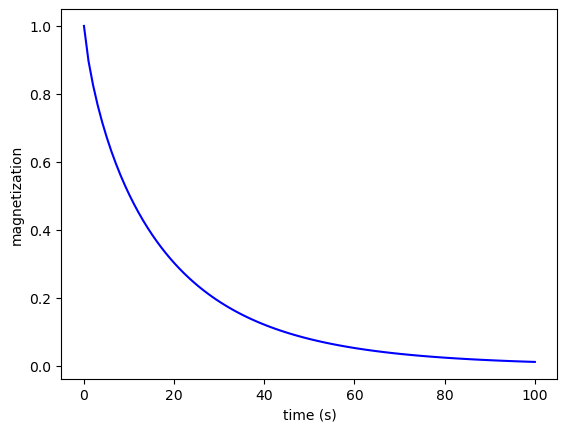

In [28]:
#Run different lattice configurations simultaneously using different CPU cores

from pathos.multiprocessing import ProcessingPool as Pool

import time
start_time = time.time()

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def FCC_lattice(a,size):

        x = a*np.array([1, 0, 0])
        y = a*np.array([0, 1, 0])
        z = a*np.array([0, 0, 1])

        offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

        # List of positions in a single unit cell for FCC structure
        fcc_positions = (a/2)*np.array([
            [0, 0, 0],  # Corner atom
            [1, 1, 0],  # Face center (x-y plane)
            [1, 0, 1],  # Face center (x-z plane)
            [0, 1, 1],  # Face center (y-z plane)
            ])

        R = []
        for l in range(-size, size+1):
            for m in range(-size, size+1):
                for n in range(-size, size+1):
                    for pos in fcc_positions:
                        R.append(l*x + m*y + n*z + pos)
                        R.append(l*x + m*y + n*z + pos + offset)

        return np.array(R)


    def place_specials(size):
        R = FCC_lattice(3.57,size)

        prob_C = 3.75*1e-2
        prob_e = 30*1e-6
        specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
        carbons = random.sample(specials, int(len(R)*prob_C))
        electrons = [pt for pt in specials if pt not in carbons]

        S = np.zeros(R.shape)
        T = np.zeros(R.shape)
        for pos in carbons:
            S[pos,:] = R[pos,:]
        for pos in electrons:
            T[pos,:] = R[pos,:]

        carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
        carbon_pts = np.array(carbon_pts)

        e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
        e_pts = np.array(e_pts)

        return carbon_pts, e_pts



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])



    def calculate_M(carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
        diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances2 = np.linalg.norm(diff2, axis=2)

        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
                r = distances2[carbon,e]
                angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((1/2)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        from scipy.spatial import cKDTree

        threshold = 20
        tree = cKDTree(outside_pts)
        pairs = tree.query_pairs(r=threshold, output_type='ndarray')  # shape: (num_pairs, 2)

        W = np.zeros((N_bulk, N_bulk))
        for i, j in pairs:
            diff = outside_pts[i] - outside_pts[j]
            dist = np.linalg.norm(diff)
            unit_vec = diff / dist
            angle = np.arccos(unit_vec[2])

            A = 1 - 3 * (np.cos(angle))**2
            B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
            W[i, j] = 0.5 * B**2 * tau_d
            W[j, i] = 0.5 * B**2 * tau_d# symmetry

        W = W - np.diag(np.sum(W, axis=0))

        M = W-R
        return N_bulk, M



    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha
    
    
    tau_p, tau_d = params
    
    size = 12
    T = np.linspace(0,100,100)
    P = np.zeros(len(T))
    carbon_pts, e_pts = place_specials(size)
    N_bulk, M = calculate_M(carbon_pts, e_pts, tau_p, tau_d)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    return P


iterations = 100
inputs = [(1.4e-6, 0.7e-2)] * iterations

pool = Pool()
results = pool.map(run_simulation, inputs)

print(np.array(results).shape)
end_time = time.time()
print(end_time-start_time)

P = np.array(results)
P_avg = (np.sum(P, axis=0))/iterations
T = np.linspace(0,100,100)
fig = plt.figure()
plt.plot(T, P_avg, color='b')
plt.xlabel('time (s)')
plt.ylabel('magnetization')
plt.show()

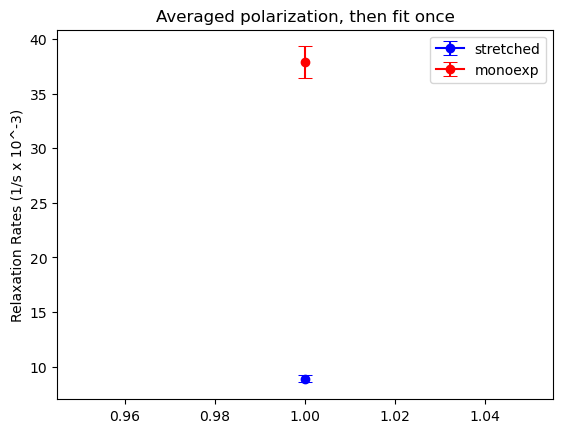

stretched rate = 8.876473093056331 \pm 0.3240397768175828
mono rate = 37.88102550274078 \pm 1.43986449685003


In [29]:
def fit_product(P,T):
    from scipy.optimize import curve_fit
    def product_exp(x, a, b):
        return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

    popt, pcov = curve_fit(product_exp, T, P, bounds=([0, 0], [1, 1]))
    stretched_rate = popt[0]*1e3
    mono_rate = popt[1]*1e3
    return stretched_rate, mono_rate

stretched_avg, mono_avg = fit_product(P_avg,T)

stretched_rate = np.zeros((iterations))
mono_rate = np.zeros((iterations))

for j in range(iterations):
    stretched_rate[j], mono_rate[j] = fit_product(P[j,:],T)
    
stretched_mean = np.mean(stretched_rate)
mono_mean = np.mean(mono_rate)

stretched_error = (np.sqrt(np.var(stretched_rate)/iterations))
mono_error = (np.sqrt(np.var(mono_rate)/iterations))

fig = plt.figure()
plt.errorbar(1, stretched_avg, stretched_error, fmt='-o', capsize=5, capthick=0.75, color = 'blue', label = 'stretched')
plt.errorbar(1, mono_avg, mono_error, fmt='-o', capsize=5, capthick=0.75, color = 'red', label = 'monoexp') 
plt.title("Averaged polarization, then fit once")
# plt.xlabel("1/tau_c (1/s)")
plt.ylabel("Relaxation Rates (1/s x 10^-3)")
plt.legend()
plt.show()

print("stretched rate =", stretched_avg, "\pm", stretched_error)
print("mono rate =", mono_avg, "\pm", mono_error)

filename = f"3.75%_RelaxationRates.npz"
np.savez(filename, S = stretched_rate, M = mono_rate, S_avg = stretched_avg, M_avg = mono_avg)

# fig.savefig("C:\\Users\\Suber\\Desktop\\Regime1_new.eps", format='eps', dpi=300)

(100, 100)
3333.423773288727


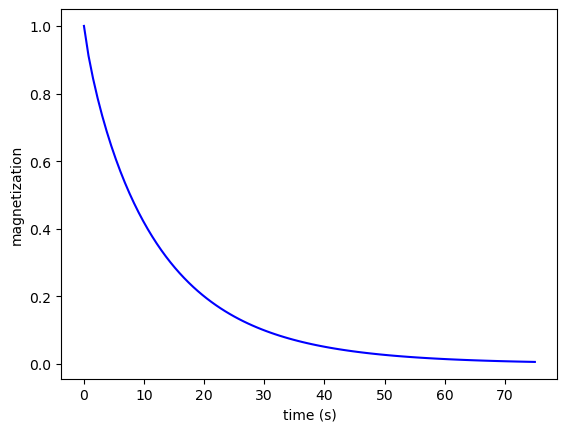

In [30]:
#Run different lattice configurations simultaneously using different CPU cores

from pathos.multiprocessing import ProcessingPool as Pool

import time
start_time = time.time()

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def FCC_lattice(a,size):

        x = a*np.array([1, 0, 0])
        y = a*np.array([0, 1, 0])
        z = a*np.array([0, 0, 1])

        offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

        # List of positions in a single unit cell for FCC structure
        fcc_positions = (a/2)*np.array([
            [0, 0, 0],  # Corner atom
            [1, 1, 0],  # Face center (x-y plane)
            [1, 0, 1],  # Face center (x-z plane)
            [0, 1, 1],  # Face center (y-z plane)
            ])

        R = []
        for l in range(-size, size+1):
            for m in range(-size, size+1):
                for n in range(-size, size+1):
                    for pos in fcc_positions:
                        R.append(l*x + m*y + n*z + pos)
                        R.append(l*x + m*y + n*z + pos + offset)

        return np.array(R)


    def place_specials(size):
        R = FCC_lattice(3.57,size)

        prob_C = 6.25*1e-2
        prob_e = 30*1e-6
        specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
        carbons = random.sample(specials, int(len(R)*prob_C))
        electrons = [pt for pt in specials if pt not in carbons]

        S = np.zeros(R.shape)
        T = np.zeros(R.shape)
        for pos in carbons:
            S[pos,:] = R[pos,:]
        for pos in electrons:
            T[pos,:] = R[pos,:]

        carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
        carbon_pts = np.array(carbon_pts)

        e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
        e_pts = np.array(e_pts)

        return carbon_pts, e_pts



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])



    def calculate_M(carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
        diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances2 = np.linalg.norm(diff2, axis=2)

        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
                r = distances2[carbon,e]
                angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((1/2)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        from scipy.spatial import cKDTree

        threshold = 20
        tree = cKDTree(outside_pts)
        pairs = tree.query_pairs(r=threshold, output_type='ndarray')  # shape: (num_pairs, 2)

        W = np.zeros((N_bulk, N_bulk))
        for i, j in pairs:
            diff = outside_pts[i] - outside_pts[j]
            dist = np.linalg.norm(diff)
            unit_vec = diff / dist
            angle = np.arccos(unit_vec[2])

            A = 1 - 3 * (np.cos(angle))**2
            B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
            W[i, j] = 0.5 * B**2 * tau_d
            W[j, i] = 0.5 * B**2 * tau_d# symmetry

        W = W - np.diag(np.sum(W, axis=0))

        M = W-R
        return N_bulk, M



    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha
    
    
    tau_p, tau_d = params
    
    size = 12
    T = np.linspace(0,75,100)
    P = np.zeros(len(T))
    carbon_pts, e_pts = place_specials(size)
    N_bulk, M = calculate_M(carbon_pts, e_pts, tau_p, tau_d)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    return P


iterations = 100
inputs = [(1.4e-6, 0.7e-2)] * iterations

pool = Pool()
results = pool.map(run_simulation, inputs)

print(np.array(results).shape)
end_time = time.time()
print(end_time-start_time)

P = np.array(results)
P_avg = (np.sum(P, axis=0))/iterations
T = np.linspace(0,75,100)
fig = plt.figure()
plt.plot(T, P_avg, color='b')
plt.xlabel('time (s)')
plt.ylabel('magnetization')
plt.show()

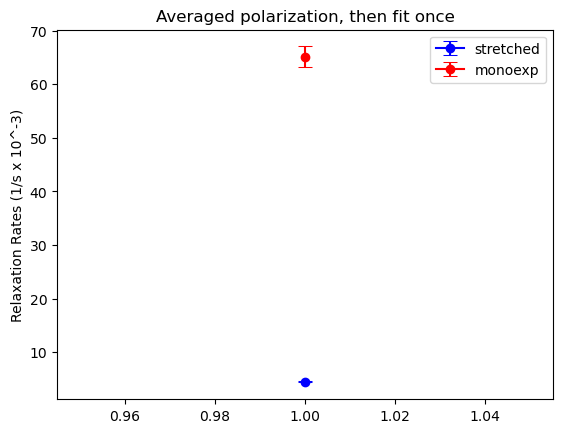

stretched rate = 4.527692796084117 \pm 0.1672912616011027
mono rate = 65.10955409863644 \pm 1.9278206475097366


In [31]:
def fit_product(P,T):
    from scipy.optimize import curve_fit
    def product_exp(x, a, b):
        return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

    popt, pcov = curve_fit(product_exp, T, P, bounds=([0, 0], [1, 1]))
    stretched_rate = popt[0]*1e3
    mono_rate = popt[1]*1e3
    return stretched_rate, mono_rate

stretched_avg, mono_avg = fit_product(P_avg,T)

stretched_rate = np.zeros((iterations))
mono_rate = np.zeros((iterations))

for j in range(iterations):
    stretched_rate[j], mono_rate[j] = fit_product(P[j,:],T)
    
stretched_mean = np.mean(stretched_rate)
mono_mean = np.mean(mono_rate)

stretched_error = (np.sqrt(np.var(stretched_rate)/iterations))
mono_error = (np.sqrt(np.var(mono_rate)/iterations))

fig = plt.figure()
plt.errorbar(1, stretched_avg, stretched_error, fmt='-o', capsize=5, capthick=0.75, color = 'blue', label = 'stretched')
plt.errorbar(1, mono_avg, mono_error, fmt='-o', capsize=5, capthick=0.75, color = 'red', label = 'monoexp') 
plt.title("Averaged polarization, then fit once")
# plt.xlabel("1/tau_c (1/s)")
plt.ylabel("Relaxation Rates (1/s x 10^-3)")
plt.legend()
plt.show()

print("stretched rate =", stretched_avg, "\pm", stretched_error)
print("mono rate =", mono_avg, "\pm", mono_error)

filename = f"6.25%_RelaxationRates.npz"
np.savez(filename, S = stretched_rate, M = mono_rate, S_avg = stretched_avg, M_avg = mono_avg)

# fig.savefig("C:\\Users\\Suber\\Desktop\\Regime1_new.eps", format='eps', dpi=300)

(100, 100)
7551.128573894501


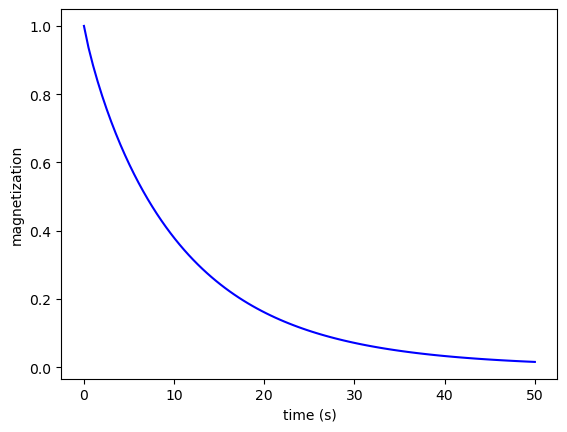

In [197]:
#Run different lattice configurations simultaneously using different CPU cores

from pathos.multiprocessing import ProcessingPool as Pool

import time
start_time = time.time()

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def FCC_lattice(a,size):

        x = a*np.array([1, 0, 0])
        y = a*np.array([0, 1, 0])
        z = a*np.array([0, 0, 1])

        offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

        # List of positions in a single unit cell for FCC structure
        fcc_positions = (a/2)*np.array([
            [0, 0, 0],  # Corner atom
            [1, 1, 0],  # Face center (x-y plane)
            [1, 0, 1],  # Face center (x-z plane)
            [0, 1, 1],  # Face center (y-z plane)
            ])

        R = []
        for l in range(-size, size+1):
            for m in range(-size, size+1):
                for n in range(-size, size+1):
                    for pos in fcc_positions:
                        R.append(l*x + m*y + n*z + pos)
                        R.append(l*x + m*y + n*z + pos + offset)

        return np.array(R)


    def place_specials(size):
        R = FCC_lattice(3.57,size)

        prob_C = 8.75*1e-2
        prob_e = 30*1e-6
        specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
        carbons = random.sample(specials, int(len(R)*prob_C))
        electrons = [pt for pt in specials if pt not in carbons]

        S = np.zeros(R.shape)
        T = np.zeros(R.shape)
        for pos in carbons:
            S[pos,:] = R[pos,:]
        for pos in electrons:
            T[pos,:] = R[pos,:]

        carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
        carbon_pts = np.array(carbon_pts)

        e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
        e_pts = np.array(e_pts)

        return carbon_pts, e_pts



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])



    def calculate_M(carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
        diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances2 = np.linalg.norm(diff2, axis=2)

        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
                r = distances2[carbon,e]
                angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((1/2)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        from scipy.spatial import cKDTree

        threshold = 20
        tree = cKDTree(outside_pts)
        pairs = tree.query_pairs(r=threshold, output_type='ndarray')  # shape: (num_pairs, 2)

        W = np.zeros((N_bulk, N_bulk))
        for i, j in pairs:
            diff = outside_pts[i] - outside_pts[j]
            dist = np.linalg.norm(diff)
            unit_vec = diff / dist
            angle = np.arccos(unit_vec[2])

            A = 1 - 3 * (np.cos(angle))**2
            B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
            W[i, j] = 0.5 * B**2 * tau_d
            W[j, i] = 0.5 * B**2 * tau_d# symmetry

        W = W - np.diag(np.sum(W, axis=0))

        M = W-R
        return N_bulk, M



    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha
    
    
    tau_p, tau_d = params
    
    size = 12
    T = np.linspace(0,50,100)
    P = np.zeros(len(T))
    carbon_pts, e_pts = place_specials(size)
    N_bulk, M = calculate_M(carbon_pts, e_pts, tau_p, tau_d)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    return P


iterations = 100
inputs = [(1.4e-6, 0.7e-2)] * iterations

pool = Pool(nodes=4)
results = pool.map(run_simulation, inputs)

print(np.array(results).shape)
end_time = time.time()
print(end_time-start_time)

P = np.array(results)
P_avg = (np.sum(P, axis=0))/iterations
T = np.linspace(0,50,100)
fig = plt.figure()
plt.plot(T, P_avg, color='b')
plt.xlabel('time (s)')
plt.ylabel('magnetization')
plt.show()

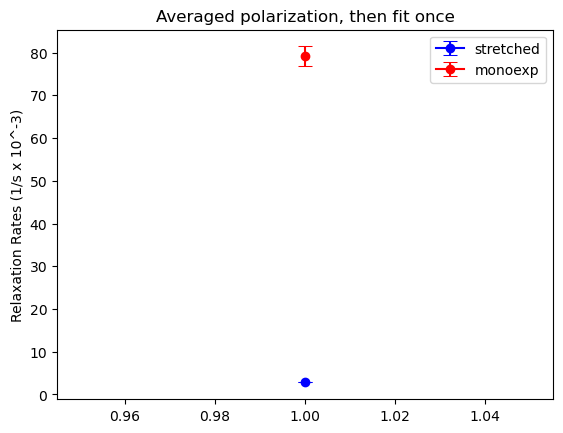

stretched rate = 2.8943437474481017 \pm 0.09666327477743203
mono rate = 79.14386091685714 \pm 2.2868220695326826


In [198]:
def fit_product(P,T):
    from scipy.optimize import curve_fit
    def product_exp(x, a, b):
        return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

    popt, pcov = curve_fit(product_exp, T, P, bounds=([0, 0], [1, 1]))
    stretched_rate = popt[0]*1e3
    mono_rate = popt[1]*1e3
    return stretched_rate, mono_rate

stretched_avg, mono_avg = fit_product(P_avg,T)

stretched_rate = np.zeros((iterations))
mono_rate = np.zeros((iterations))

for j in range(iterations):
    stretched_rate[j], mono_rate[j] = fit_product(P[j,:],T)
    
stretched_mean = np.mean(stretched_rate)
mono_mean = np.mean(mono_rate)

stretched_error = (np.sqrt(np.var(stretched_rate)/iterations))
mono_error = (np.sqrt(np.var(mono_rate)/iterations))

fig = plt.figure()
plt.errorbar(1, stretched_avg, stretched_error, fmt='-o', capsize=5, capthick=0.75, color = 'blue', label = 'stretched')
plt.errorbar(1, mono_avg, mono_error, fmt='-o', capsize=5, capthick=0.75, color = 'red', label = 'monoexp') 
plt.title("Averaged polarization, then fit once")
# plt.xlabel("1/tau_c (1/s)")
plt.ylabel("Relaxation Rates (1/s x 10^-3)")
plt.legend()
plt.show()

print("stretched rate =", stretched_avg, "\pm", stretched_error)
print("mono rate =", mono_avg, "\pm", mono_error)

filename = f"8.75%_RelaxationRates.npz"
np.savez(filename, S = stretched_rate, M = mono_rate, S_avg = stretched_avg, M_avg = mono_avg)

# fig.savefig("C:\\Users\\Suber\\Desktop\\Regime1_new.eps", format='eps', dpi=300)

(100, 100)
16072.20705795288


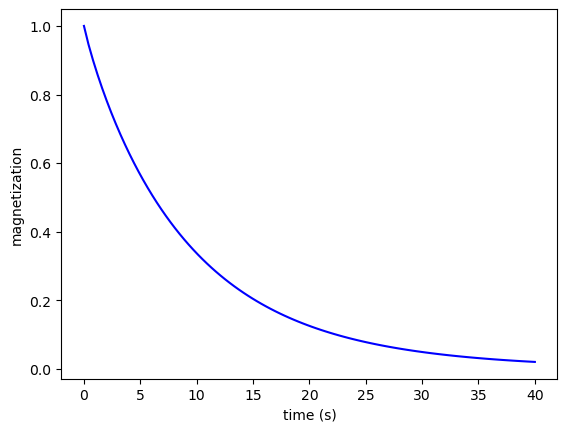

In [199]:
#Run different lattice configurations simultaneously using different CPU cores

from pathos.multiprocessing import ProcessingPool as Pool

import time
start_time = time.time()

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def FCC_lattice(a,size):

        x = a*np.array([1, 0, 0])
        y = a*np.array([0, 1, 0])
        z = a*np.array([0, 0, 1])

        offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

        # List of positions in a single unit cell for FCC structure
        fcc_positions = (a/2)*np.array([
            [0, 0, 0],  # Corner atom
            [1, 1, 0],  # Face center (x-y plane)
            [1, 0, 1],  # Face center (x-z plane)
            [0, 1, 1],  # Face center (y-z plane)
            ])

        R = []
        for l in range(-size, size+1):
            for m in range(-size, size+1):
                for n in range(-size, size+1):
                    for pos in fcc_positions:
                        R.append(l*x + m*y + n*z + pos)
                        R.append(l*x + m*y + n*z + pos + offset)

        return np.array(R)


    def place_specials(size):
        R = FCC_lattice(3.57,size)

        prob_C = 11.25*1e-2
        prob_e = 30*1e-6
        specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
        carbons = random.sample(specials, int(len(R)*prob_C))
        electrons = [pt for pt in specials if pt not in carbons]

        S = np.zeros(R.shape)
        T = np.zeros(R.shape)
        for pos in carbons:
            S[pos,:] = R[pos,:]
        for pos in electrons:
            T[pos,:] = R[pos,:]

        carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
        carbon_pts = np.array(carbon_pts)

        e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
        e_pts = np.array(e_pts)

        return carbon_pts, e_pts



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])



    def calculate_M(carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
        diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances2 = np.linalg.norm(diff2, axis=2)

        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
                r = distances2[carbon,e]
                angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((1/2)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        from scipy.spatial import cKDTree

        threshold = 20
        tree = cKDTree(outside_pts)
        pairs = tree.query_pairs(r=threshold, output_type='ndarray')  # shape: (num_pairs, 2)

        W = np.zeros((N_bulk, N_bulk))
        for i, j in pairs:
            diff = outside_pts[i] - outside_pts[j]
            dist = np.linalg.norm(diff)
            unit_vec = diff / dist
            angle = np.arccos(unit_vec[2])

            A = 1 - 3 * (np.cos(angle))**2
            B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
            W[i, j] = 0.5 * B**2 * tau_d
            W[j, i] = 0.5 * B**2 * tau_d# symmetry

        W = W - np.diag(np.sum(W, axis=0))

        M = W-R
        return N_bulk, M



    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha
    
    
    tau_p, tau_d = params
    
    size = 12
    T = np.linspace(0,40,100)
    P = np.zeros(len(T))
    carbon_pts, e_pts = place_specials(size)
    N_bulk, M = calculate_M(carbon_pts, e_pts, tau_p, tau_d)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    return P


iterations = 100
inputs = [(1.4e-6, 0.7e-2)] * iterations

pool = Pool(nodes=2)
results = pool.map(run_simulation, inputs)

print(np.array(results).shape)
end_time = time.time()
print(end_time-start_time)

P = np.array(results)
P_avg = (np.sum(P, axis=0))/iterations
T = np.linspace(0,40,100)
fig = plt.figure()
plt.plot(T, P_avg, color='b')
plt.xlabel('time (s)')
plt.ylabel('magnetization')
plt.show()

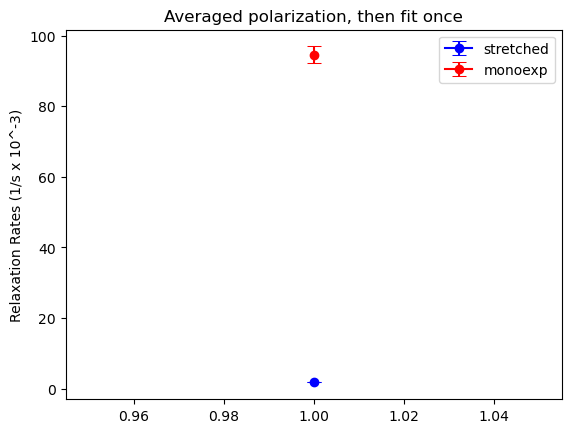

stretched rate = 1.800702446561584 \pm 0.05434214831520811
mono rate = 94.54569523269691 \pm 2.365595613194404


In [200]:
def fit_product(P,T):
    from scipy.optimize import curve_fit
    def product_exp(x, a, b):
        return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

    popt, pcov = curve_fit(product_exp, T, P, bounds=([0, 0], [1, 1]))
    stretched_rate = popt[0]*1e3
    mono_rate = popt[1]*1e3
    return stretched_rate, mono_rate

stretched_avg, mono_avg = fit_product(P_avg,T)

stretched_rate = np.zeros((iterations))
mono_rate = np.zeros((iterations))

for j in range(iterations):
    stretched_rate[j], mono_rate[j] = fit_product(P[j,:],T)
    
stretched_mean = np.mean(stretched_rate)
mono_mean = np.mean(mono_rate)

stretched_error = (np.sqrt(np.var(stretched_rate)/iterations))
mono_error = (np.sqrt(np.var(mono_rate)/iterations))

fig = plt.figure()
plt.errorbar(1, stretched_avg, stretched_error, fmt='-o', capsize=5, capthick=0.75, color = 'blue', label = 'stretched')
plt.errorbar(1, mono_avg, mono_error, fmt='-o', capsize=5, capthick=0.75, color = 'red', label = 'monoexp') 
plt.title("Averaged polarization, then fit once")
# plt.xlabel("1/tau_c (1/s)")
plt.ylabel("Relaxation Rates (1/s x 10^-3)")
plt.legend()
plt.show()

print("stretched rate =", stretched_avg, "\pm", stretched_error)
print("mono rate =", mono_avg, "\pm", mono_error)

filename = f"11.25%_RelaxationRates.npz"
np.savez(filename, S = stretched_rate, M = mono_rate, S_avg = stretched_avg, M_avg = mono_avg)

# fig.savefig("C:\\Users\\Suber\\Desktop\\Regime1_new.eps", format='eps', dpi=300)

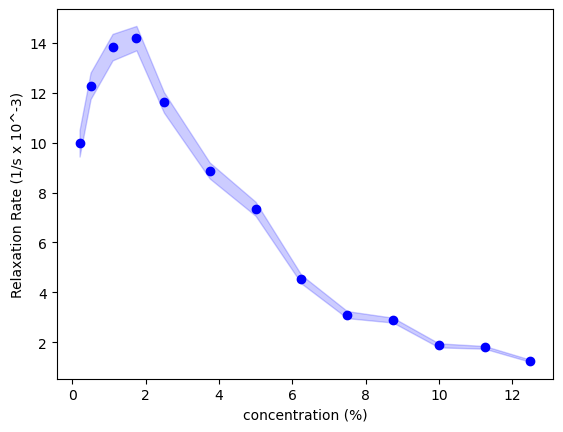

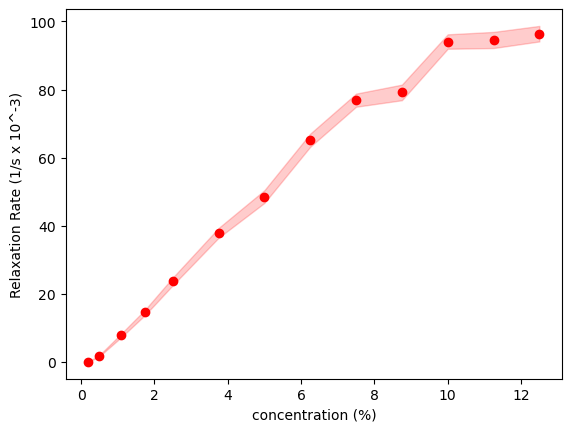

In [201]:
x = np.array((0.2, 0.5, 1.1, 1.75, 2.5, 3.75, 5, 6.25, 7.5, 8.75, 10, 11.25, 12.5))
Rp = np.array((9.97, 12.27, 13.82, 14.18, 11.61, 8.88, 7.35, 4.53, 3.11, 2.89, 1.88, 1.80, 1.26))
Rd = np.array((0, 1.82, 7.8, 14.59, 23.62, 37.88, 48.55, 65.11, 76.86, 79.14, 94.09, 94.55, 96.4))
Rp_error = np.array((0.53, 0.53, 0.53, 0.49, 0.41, 0.32, 0.28, 0.17, 0.14, 0.097, 0.08, 0.054, 0.043))
Rd_error = np.array((0.036, 0.18, 0.53, 0.79, 1.12, 1.44, 1.87, 1.93, 1.93, 2.29, 2.12, 2.37, 2.28))


fig = plt.figure()
plt.scatter(x, Rp, color='b')
# plt.scatter(x, y2, color='r')
plt.xlabel("concentration (%)")
plt.ylabel("Relaxation Rate (1/s x 10^-3)")
plt.fill_between(x, Rp - Rp_error, Rp + Rp_error,
                 color='blue', alpha=0.2, label='Error band')
plt.show()
fig = plt.figure()
# plt.scatter(x, y1, color='b')
plt.scatter(x, Rd, color='r')
plt.xlabel("concentration (%)")
plt.ylabel("Relaxation Rate (1/s x 10^-3)")
plt.fill_between(x, Rd - Rd_error, Rd + Rd_error,
                 color='red', alpha=0.2, label='Error band')
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\RdWithConcentration.eps", format='eps', dpi=300)